# Topic: Predict Future Sales


**Author: Tsung-Chin Han**

**Presentation Date: April 17th, 2019**


# Introduction:

In this notebook, we implement a gradient boosting algorithm and predict number of items sold for the next month (output field: item_cnt_month) per store per item ('ID' in the output table stands for tuple of shop_id and item_id). All items are digital in nature such as PC, game consoles, computer games, music, etc.

# 0 - Packages dependencies

In [3]:
# plot inline
%matplotlib inline

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
import seaborn as sns
import graphviz

# machine learing
from xgboost import XGBRegressor
from xgboost import plot_importance
from xgboost import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

# other
import csv
from datetime import datetime
from datetime import date
import holidays
import gzip
import zipfile
from geotext import GeoText
from itertools import product

# mute warnings
import warnings
warnings.filterwarnings('ignore')


# 1 - Data Preparation

### 1.1 - Load Data

load our train and test data.
Due to excel number of rows limitation, will handle unpackaging data set here.


In [4]:
# unzip the zip file from Kaggle
zip = zipfile.ZipFile('competitive-data-science-predict-future-sales.zip')
zip.extractall()

# read in data
file_1 = gzip.open('sales_train.csv.gz')
train_sales_data = pd.read_csv(file_1, parse_dates=['date']) # with datetime transform

file_2 = gzip.open('test.csv.gz')
test_data = pd.read_csv(file_2)

# load item, shop, and item category
items_category_data = pd.read_csv('item_categories-translated.csv')
items_data = pd.read_csv('items.csv')
shops_data = pd.read_csv('shops-translated.csv')

# Check dimensions
print(f"""
1. Train data shape: {train_sales_data.shape}
2. Test data shape: {test_data.shape}
3. items category data: {items_category_data.shape}
4. items data: {items_data.shape}
5. shops data: {shops_data.shape}

""")



1. Train data shape: (2935849, 6)
2. Test data shape: (214200, 3)
3. items category data: (84, 2)
4. items data: (22170, 3)
5. shops data: (60, 2)




### 1.2 - Join all data togther
**after joining the data, we take a quick look at our data.**

In [5]:
# join all data together
train_final = train_sales_data.join(items_data, on='item_id', rsuffix='_') \
             .join(shops_data, on='shop_id', rsuffix='_') \
             .join(items_category_data, on='item_category_id', rsuffix='_') \
             .drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

# check dimension for the joined data
print(f"""
Joined data shape: {train_final.shape}
""")

# take a quick look at our train data
train_final.head()



Joined data shape: (2935849, 10)



,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name_translated,item_category_name_translated
0,2013-02-01,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Yaroslavl Shopping center ""Altair""",Cinema - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Moscow TRK ""Atrium""",Music - Vinyl
2,2013-05-01,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Moscow TRK ""Atrium""",Music - Vinyl
3,2013-06-01,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Moscow TRK ""Atrium""",Music - Vinyl
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Moscow TRK ""Atrium""",Music - CD of branded production


**Lets have a quick look at our test data too.**

In [6]:
# take a quick look at our test data
print(f"""
test data shape: {test_data.shape}  
""")

test_data.head()



test data shape: (214200, 3)  



,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


### 1.3 - Data type
**summary dtype and stats.**


In [7]:
# summary dtype
print(train_final.info())

# summary stats
print(train_final.describe())

# check our date range
print('\nStart date from train data: {}'.format(train_final['date'].min().date()))
print('End date from train data: {}'.format(train_final['date'].max().date()))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
date                             datetime64[ns]
date_block_num                   int64
shop_id                          int64
item_id                          int64
item_price                       float64
item_cnt_day                     float64
item_name                        object
item_category_id                 int64
shop_name_translated             object
item_category_name_translated    object
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 224.0+ MB
None
       date_block_num       shop_id       item_id    item_price  item_cnt_day  \
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06   
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00   
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00   
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.20

### 1.4 - Firstline data cleaning & features adding

In [8]:
# negative item price needs to be fixed. Treat as typo and flip the sign.
train_final["item_price"] = np.where(train_final["item_price"]<0, train_final["item_price"]*-1, train_final["item_price"])

# remove returned items from train set as it isn't reliable to predict returns
train_final = train_final[train_final['item_cnt_day']>=0]

# add day of week
train_final['DayofWeek'] = train_final['date'].apply(lambda time: time.dayofweek)

#add holiday indicator
russian_holidays = holidays.Russia(years =[2012,2013,2014,2015,2016,2017,2018])
train_final['holiday'] = train_final['date'].isin(russian_holidays)*1 # convert to numberic

# add city location and assign "other" if city isn't available
train_final['city'] = train_final['shop_name_translated'].str.split().str.get(0)
train_final['city'].unique()
train_final["city"] = np.where(train_final["city"].isin(['Online','Outbound','Digital','0']),
                               'other',
                               train_final["city"])
# add category 
train_final['cat'] = train_final['item_category_name_translated'].str.split().str.get(0)
train_final['cat'].unique()


# add revenue = price * count
train_final["revenue"] = train_final['item_price'] * train_final['item_cnt_day']

# remove data past Oct 2015 since we are going to predict Nov 2015
# remove outlier on 2013-11-29, soon after PS4 was released.
train_final = train_final.query('date <= datetime(2015,10,31) and date != datetime(2013,11,29)')

#sort data by date since it's time series
train_final= train_final.sort_values(by='date')

# take a quick look
print(train_final.head())
print(train_final.tail())


             date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
18524  2013-01-01               0       28     2415       299.0           1.0   
110630 2013-01-01               0       42     5627      2380.0           1.0   
17019  2013-01-01               0       28      998        99.0           1.0   
18024  2013-01-01               0       28     3698       599.0           1.0   
109380 2013-01-01               0       46    20391      1599.0           1.0   

                                                item_name  item_category_id  \
18524        Counter Strike 1. Антология (PC-DVD) (Jewel)                30   
110630  PS3: Контроллер игровой беспроводной белый (Du...                 2   
17019           3D Action Puzzle "Зомби " Железнодорожник                67   
18024   God of War: Призрак Спарты (Essentials) [PSP, ...                21   
109380  Фигурка Assassin's Creed Revelations Ezio Blac...                72   

                  shop_name_translated

**Check if identified cities are real**

In [9]:
train_final['city'].unique()

array(['Moscow', 'SPb', 'Sergiev', 'Kazan', 'Omsk', 'Tyumen', 'Voronezh',
       'Khimki', 'Kaluga', 'Kursk', 'Adygea', 'Novosibirsk',
       'RostovNaDonu', 'Krasnoyarsk', 'Nizhny', 'Yakutsk', 'other',
       'Zhukovsky', 'Surgut', 'Samara', 'Ufa', 'Chekhov', 'Yaroslavl',
       'Colosseum', 'Volzhsky', 'Balashikha', 'Vologda', 'RostovNaDon',
       'Tomsk', 'N.Novgorod', 'Mytischi'], dtype=object)

### 1.5 - Target ID (shop_id & item_id) in test data
**make sure we target for the ID exists in the test data, as we are predicting them.**
**drop reundent information**

In [10]:
# filter shops exist only in test data
train_final = train_final[train_final['shop_id'].isin(test_data['shop_id'].unique())]
# filter items exist only in test data
train_final = train_final[train_final['item_id'].isin(test_data['item_id'].unique())]

# drop redundent information

train_final = train_final.drop(columns=['item_name',
                                        'shop_name_translated'
                                       ])


### 1.6 - Data Transformation & Feature Engineering Part I
**Since We need to predict number of products sold for each shop and item in next month (Nov. 2015), we are going to aggregate our daily time series data by month for predicting next month sales.**

Column "date_block_num" provides us to group by month and aggregate monthly features (more features added).

In [11]:
# copy data to form our modeling data (keep original data untouched)
train_final_monthly = train_final.copy()

#column "date_block_num" provides us to group by month. non-aggregate features include in index and keep
train_final_monthly = train_final_monthly.groupby(['date_block_num', 
                                                   'shop_id', 
                                                   'item_id',
                                                   'item_category_id',
                                                   'DayofWeek',
                                                   'city',
                                                   'cat'
                                                  ], as_index=False)

# aggregate features to monthly levels & extract more features
train_final_monthly = train_final_monthly.agg({'item_price':['sum', 'mean', 'max', 'min'], 
                                               'item_cnt_day':['sum', 'mean','count'],
                                               'holiday':['sum'],
                                               'revenue':['sum', 'mean']
                                              })

# rename columns
train_final_monthly.columns = [
    'date_block_num', 
    'shop_id', 
    'item_id',
    'item_category_id',
    'DayofWeek',
    'city',
    'cat',
    'item_price_monthly', 'mean_item_price_monthly', 'max_item_price_monthly', 'min_item_price_monthly', 
    'item_cnt_monthly', 'mean_item_cnt_monthly', 'sold_frequency', 
    'holiday_num', 
    'revenue_monthly', 'mean_revenue_monthly'     
                              ]


**Next step is to include all possible combination from the shop_id and item_id, and date_block_num**

The assumption is that in each months, every stores should have the same items, regardless of whether it's been sold or not. 


In [12]:
# include all possible combinations
df_all = pd.DataFrame(list(product(train_final_monthly.date_block_num.unique(),
                                   train_final_monthly['shop_id'].unique(),
                                  train_final_monthly['item_id'].unique())),
                      columns=['date_block_num','shop_id','item_id'])


In [13]:
df_all.head()

,date_block_num,shop_id,item_id
0,0,2,33
1,0,2,482
2,0,2,491
3,0,2,839
4,0,2,1007


**Finally, we merge train data with all possible combinations**

This is our modeling train data. we check again the modleing dimensions.

In [14]:
# merge data to form modeling train data
train_final_monthly_final = train_final_monthly.merge(df_all, 
                         on=['date_block_num','shop_id','item_id'], 
                         how='left')

# fill nan with 0
train_final_monthly_final.fillna(0, inplace=True)

# check dimensions
print(train_final_monthly_final.shape)


(1000488, 17)


**Adding calendar year and month features.**

In [15]:
# calendar year
train_final_monthly_final['year'] = train_final_monthly_final['date_block_num'].apply(lambda x: (2013 + (x//12)))

# calendar month
train_final_monthly_final['month'] = train_final_monthly_final['date_block_num'].apply(lambda x: (x % 12))



# 2 - Exploratory Data Analysis

**helper function**

In [16]:
def plot_line (data, i, title):
    """
    help function to do lineplot for each month and items sold
    
    Args(dataframe, int, str):
        data(dataframe): dataframe to plot
        i(int): Axes object to draw the plot onto
        title(string): title of the plot
        
    Return(plot): line plot
    """
    sns.lineplot(x='month', 
             y='item_cnt_monthly', 
             data=data, 
             ax=axes[i]).set_title(title)


In [17]:
def plot_bar(x, y, dataset, title):
    """
    help function to do bar plot based on shop ID
    
    Args(str, dataframe,str):
        x(string): x axis label
        y(string): y axis label
        dataset(dataframe): dataframe to plot
        title(string): title of the plot
        
    Return(plot): bar plot
    """
    fig, axes = plt.subplots(figsize=(20, 5), sharex=True)
    
    sns.barplot(x=x,
            y=y,
            data=dataset).set_title(title)
    plt.show()
    

### 2.1 - monthly behaviors - number of products sold


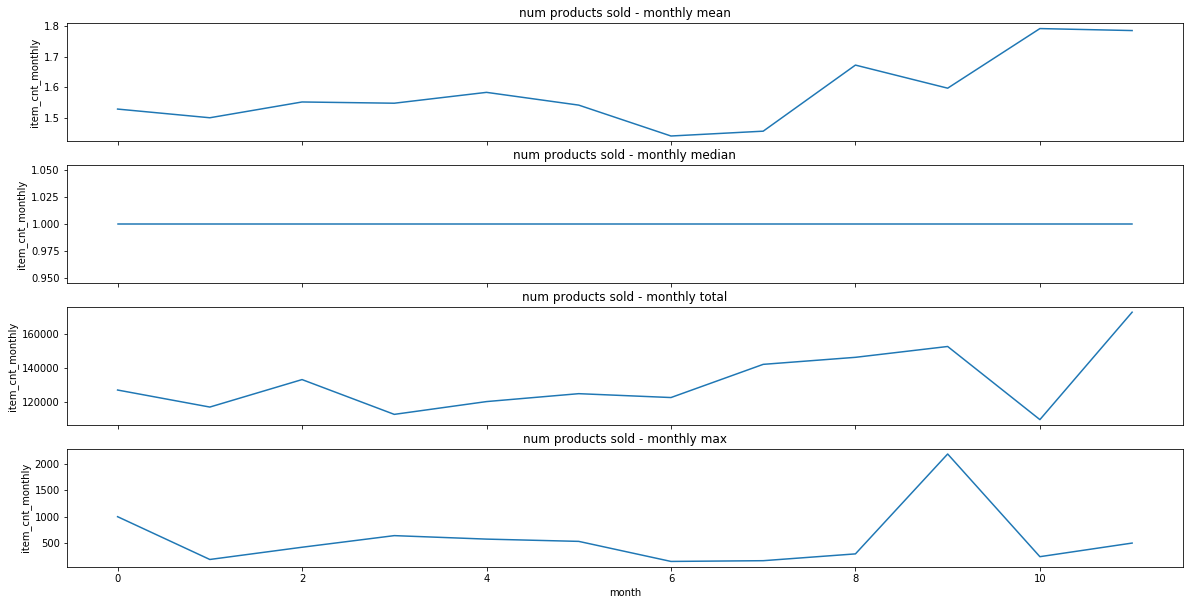

In [18]:
fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True)

plotdata = train_final_monthly_final.groupby(['month'], as_index=False)['item_cnt_monthly']

# plot mean of monthly items sold 
plot_line(plotdata.mean(),0,'num products sold - monthly mean')

# plot median of monthly items sold 
plot_line(plotdata.median(),1,'num products sold - monthly median')

# plot sum of monthly items sold 
plot_line(plotdata.sum(),2,'num products sold - monthly total')

# plot max of monthly items sold 
plot_line(plotdata.max(),3,'num products sold - monthly max')

plt.show()


### 2.2 - identify what's the best selling shop - number of products sold

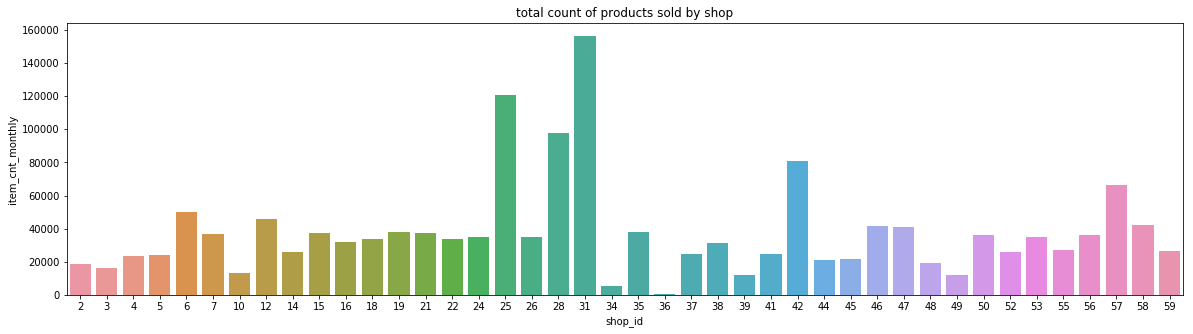

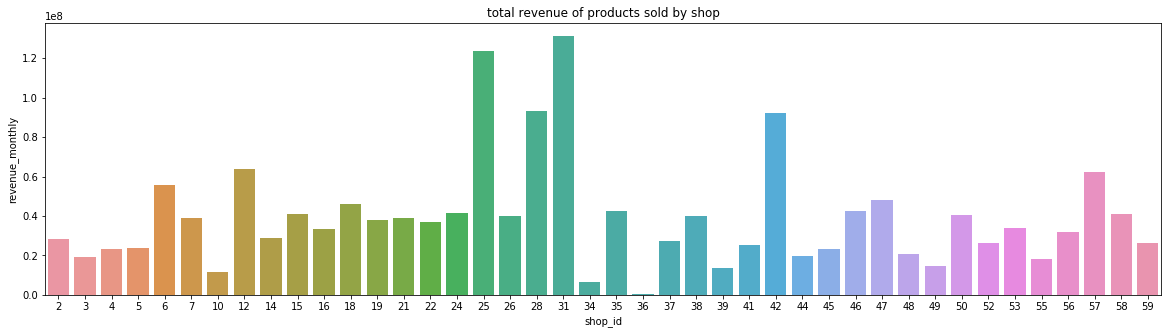

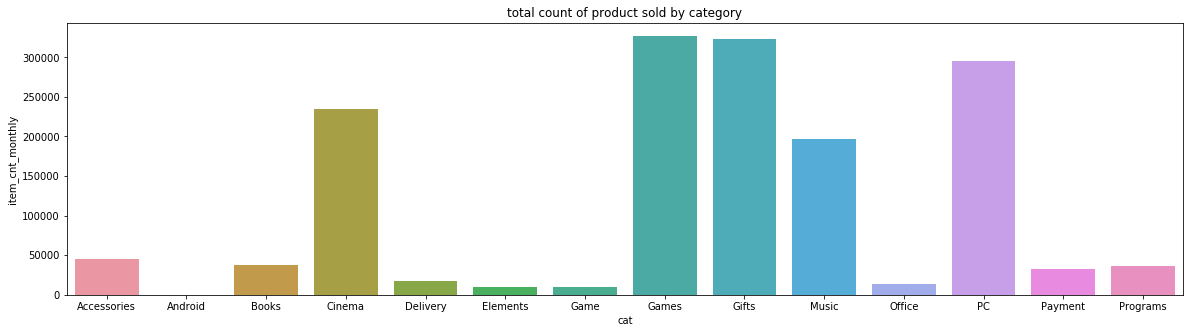

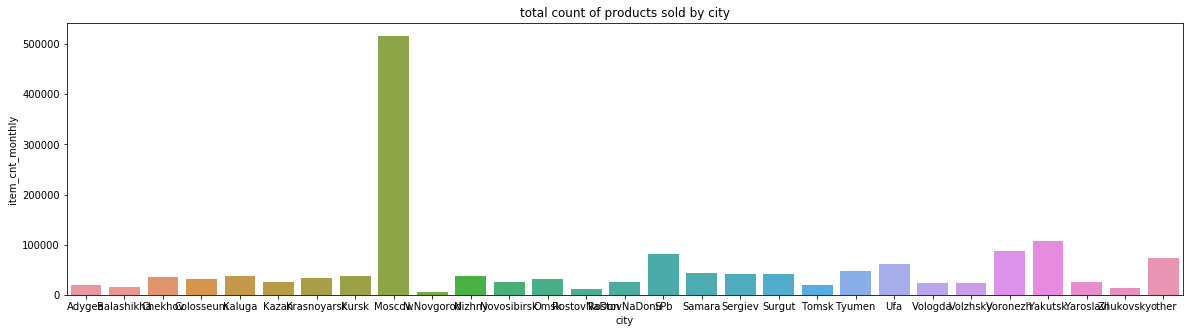

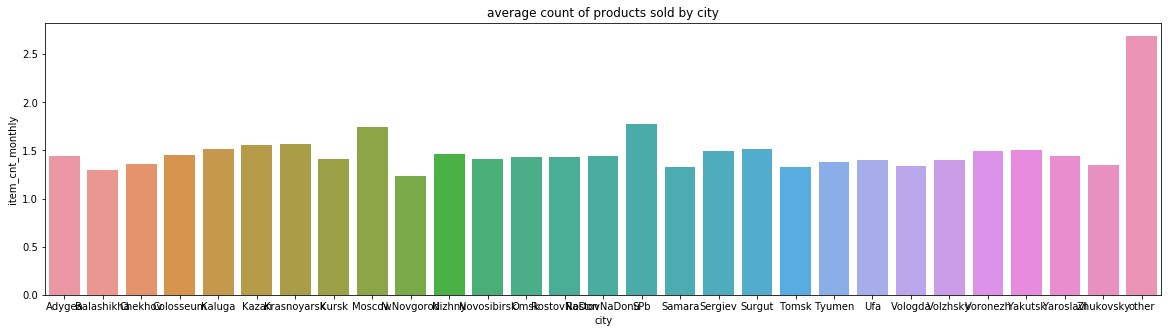

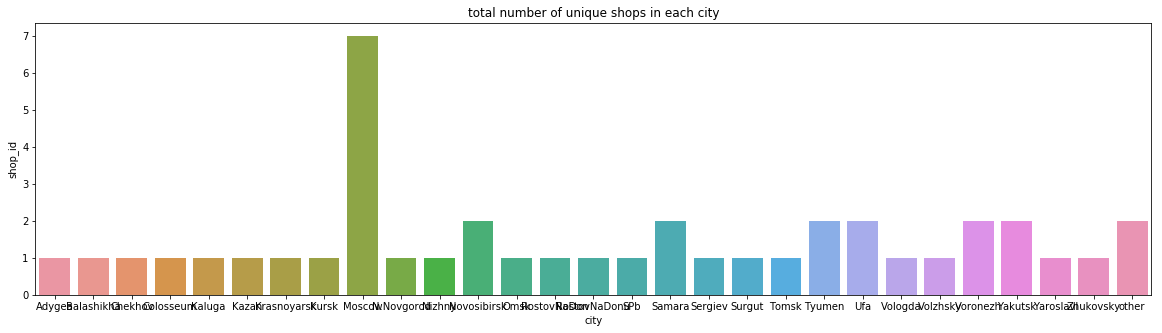

In [19]:
data_item =train_final_monthly_final.groupby(['shop_id'], as_index=False)['item_cnt_monthly'].sum()
plot_bar('shop_id','item_cnt_monthly',data_item, "total count of products sold by shop")

data_rev = train_final_monthly_final.groupby(['shop_id'], as_index=False)['revenue_monthly'].sum()
plot_bar('shop_id','revenue_monthly',data_rev, "total revenue of products sold by shop")

data_category =train_final_monthly_final.groupby(['cat'], as_index=False)['item_cnt_monthly'].sum()
plot_bar('cat','item_cnt_monthly',data_category, "total count of product sold by category")

data_city = train_final_monthly_final.groupby(['city'], as_index=False)['item_cnt_monthly'].sum()
plot_bar('city','item_cnt_monthly',data_city, 'total count of products sold by city')

data_city_avg = train_final_monthly_final.groupby(['city'], as_index=False)['item_cnt_monthly'].mean()
plot_bar('city','item_cnt_monthly',data_city_avg, 'average count of products sold by city')

data_shop = train_final_monthly_final.groupby("city").agg({"shop_id":pd.Series.nunique}).reset_index()
plot_bar('city','shop_id',data_shop, 'total number of unique shops in each city')


- total count of products sold by shop:
identify what's the best selling shop - based on total number of items sold -- Shop 31 has the most number of items sold

- total revenue of products sold by shop:
identify what's the best selling shop - based on total revenue -- shop 31 has the highest revenue, but shop 25's revenue is not far even though the number of items sold are much less. It indicates that shop 25 sold more high price items.

- total count of product sold by category:
games, pc, music, and gifts have the largest number of items sold. Games, music and gifts makes sense since they are cheaper, day-to-day items. PC's number is a little surprising.

- total count of products sold by city:
Moscow has the largest number of items sold but it's unclear if it's because more shops are in Moscow or the shops in Moscow sells more items. 

- total number of unique shops in each city:
Moscow has the most shops which drives larger sales. Larger sales in Moscow is not driven by larger sales at each shop.

- average count of products sold by city:
from this chart, we can see that moscow doesnt have the highest average number of items sold, so it just has a lot more shops than other cities.

### 2.3 - Move on to check our dependent variable (output variable)

**Firstly, get a sense of the summary stats for the data to be modelled.**

In [20]:
train_final_monthly_final['item_cnt_monthly'].describe()


count    1.000488e+06
mean     1.580270e+00
std      4.493189e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.188000e+03
Name: item_cnt_monthly, dtype: float64

**Visualize data by boxplots - monthly number of items sold**

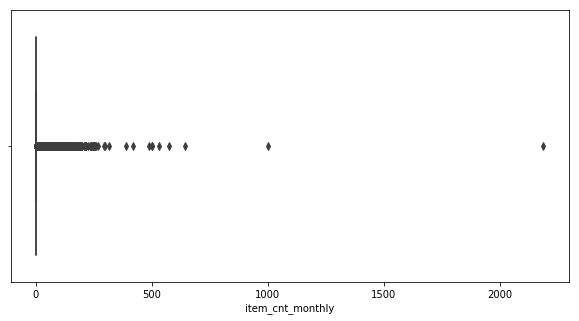

In [21]:
# boxplots
plt.subplots(figsize=(10, 5))
sns.boxplot(train_final_monthly_final['item_cnt_monthly'])
plt.show()


**Visualize the density and data distribution - monthly number of items sold**

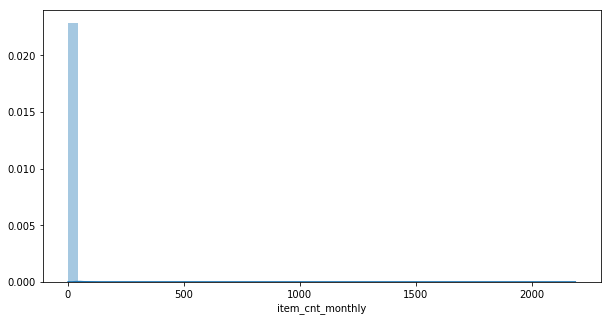

In [22]:
# density plot
plt.subplots(figsize=(10, 5))
sns.distplot(train_final_monthly_final['item_cnt_monthly'])
plt.show()


**Visualize the density and data distribution - monthly revenue**

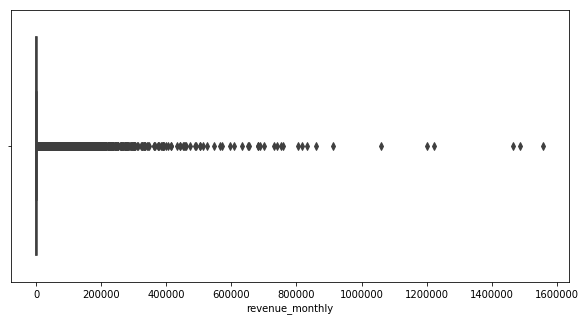

In [23]:
# boxplots - revenue
plt.subplots(figsize=(10, 5))
sns.boxplot(train_final_monthly_final['revenue_monthly'])
plt.show()


### From the observation above, the data appears to be heavily skewed to the right. Let's remove extreme outliers.


Check again for the extreme values for monthly items sold and monthly revenue.

In [24]:
print(train_final_monthly_final['item_cnt_monthly'].max())
print(train_final_monthly_final['revenue_monthly'].max())


2188.0
1558249.9999976


From the abovementioned analysis, we decided to model remove outliers down to 200 monthly items sold and keep total revenue under $50,0000.

In [25]:
# remove outliers
train_final_monthly_final = train_final_monthly_final.query('item_cnt_monthly <= 200 and revenue_monthly <= 500000')


Let's check again the maximum values after removeing those extreme outliers.

**This is going to be our modeling data for dependent variable.**

In [26]:
# after remove
print(train_final_monthly_final['item_cnt_monthly'].max())
print(train_final_monthly_final['revenue_monthly'].max())


200.0
491166.99999993


**Visualize our modeling dependent data - boxplot.**

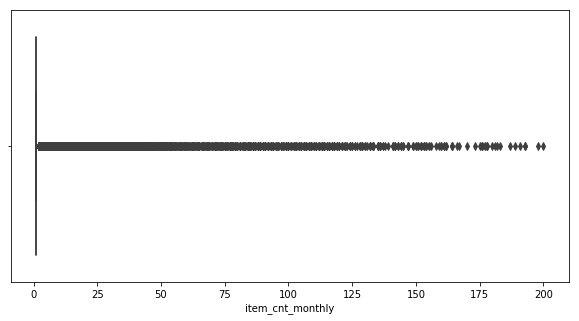

In [27]:
# boxplots
plt.subplots(figsize=(10, 5))
sns.boxplot(train_final_monthly_final['item_cnt_monthly'])
plt.show()


**Visualize our modeling dependent data - density plot (distribution).**

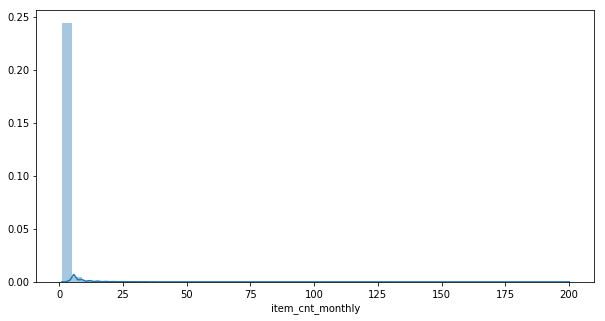

In [28]:
# density plot
plt.subplots(figsize=(10, 5))
sns.distplot(train_final_monthly_final['item_cnt_monthly'])
plt.show()


# 3 - Modeling & Machine Learning Implementation

### 3.1 - Create modeling labels
**Noted that we shift data -1, meaning $X_{t-1}$ , therefore later when we fit the model, the outcome is $Y_{t}$ already, which corresponding to the next month**

In [29]:
# create modeling labels
# shift -1 meaning X_t-1, so later when we fit the model, the outcome is Y_t already(next month)
train_final_monthly_final['item_cnt_month'] = train_final_monthly_final \
                                            .sort_values('date_block_num') \
                                            .groupby(['shop_id', 'item_id'])['item_cnt_monthly'] \
                                            .shift(-1)
            
# fill nan with 0
train_final_monthly_final['item_cnt_month'].fillna(0, inplace=True) 


### 3.2 - Feature engineering part II - add more features

**Add weekly number of products sold.**

In [30]:
# add weekly num of products sold

train_final_monthly_final['item_cnt_week'] = train_final_monthly_final \
                                            .sort_values('date_block_num') \
                                            .groupby(['shop_id', 'item_id'])['item_cnt_monthly'] \
                                            .shift(-0.25)
# fill nan with 0
train_final_monthly_final['item_cnt_week'].fillna(0, inplace=True) 


**add seasonality, trend, and volatility - monthly number of products sold.**

In [31]:
# set fucntion to add quarterly number of products sold, trend, and volatility
qtr_min = lambda x: x.rolling(3, min_periods=1).min()
qtr_max = lambda x: x.rolling(3, min_periods=1).max()
qtr_mean = lambda x: x.rolling(3, min_periods=1).mean()
qtr_std = lambda x: x.rolling(3, min_periods=1).std()

f_qtr = [qtr_min, qtr_max, qtr_mean, qtr_std]
f_col = ['qtr_min', 'qtr_max', 'qtr_mean', 'qtr_vols']


# implementation
for i in range(len(f_qtr)):
    train_final_monthly_final[('item_cnt_%s' % f_col[i])] \
    = train_final_monthly_final.sort_values('date_block_num')\
                         .groupby(['shop_id', 'item_id'])['item_cnt_monthly']\
                         .apply(f_qtr[i])

# fill nan to 0
train_final_monthly_final['item_cnt_qtr_vols'].fillna(0, inplace=True)


data type and final modeling

In [32]:
train_final_monthly_final.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000431 entries, 0 to 1000487
Data columns (total 25 columns):
date_block_num             1000431 non-null int64
shop_id                    1000431 non-null int64
item_id                    1000431 non-null int64
item_category_id           1000431 non-null int64
DayofWeek                  1000431 non-null int64
city                       1000431 non-null object
cat                        1000431 non-null object
item_price_monthly         1000431 non-null float64
mean_item_price_monthly    1000431 non-null float64
max_item_price_monthly     1000431 non-null float64
min_item_price_monthly     1000431 non-null float64
item_cnt_monthly           1000431 non-null float64
mean_item_cnt_monthly      1000431 non-null float64
sold_frequency             1000431 non-null int64
holiday_num                1000431 non-null int64
revenue_monthly            1000431 non-null float64
mean_revenue_monthly       1000431 non-null float64
year               

### 3.3 - Econde the categorical features

This is to make sure we follow the supervised learning setting that all features to be meaningful and can implement supervised learning algorithm.

**1. Based on our findings from EDA, we have item category encoded to be numeric values but still a categorical based.**

**2. For the 'city' feature, we noticed the pattern is that store in 'other' deemed outliers based on our Exploratory Analysis. As such, we seperate 'city' data by identifying where the store is 'in' other, or 'not in' other.**


In [33]:
# for item cateogory
category = {'Cinema': 1,
            'Programs':2,
            'Gifts':3,
            'Music':4,
            'Games':5,
            'PC':6,
            'Accessories':7,
            'Payment':8,
            'Books':9,
            'Office':10,
            'Elements':11,
            0:0,
            'Delivery':12,
            'Game':13,
            'Android':14
           } 

train_final_monthly_final['cat'] = [category[item] for item in train_final_monthly_final.cat] 

# for city
city = {'Adygea':0, 0:0,
        'Balashikha':0, 'Volzhsky':0,
        'Voronezh':0, 'Zhukovsky':0,
        'other':1, 'Kazan':0,
        'Kaluga':0, 'Colosseum':0,
        'Krasnoyarsk':0, 'Kursk':0, 
        'Moscow':0, 'Nizhny':0,
        'Novosibirsk':0, 'Omsk':0,
        'RostovNaDonu':0, 'SPb':0,
        'Samara':0, 'Sergiev':0,
        'Surgut':0, 'Tyumen':0,
        'Ufa':0, 'Chekhov':0,
        'Yaroslavl':0, 'Vologda':0,
        'Yakutsk':0, 'RostovNaDon':0,
        'Tomsk':0, 'N.Novgorod':0
           } 

train_final_monthly_final['city'] = [city[item] for item in train_final_monthly_final.city]



### 3.4 - Normalization
This is to make sure we follow the supervised learning setting that all features to be meaningful and can implement supervised learning algorithm.

**helper function**

In [108]:
def normalization(df, scaler=MinMaxScaler):
    """ This is to normalize the pandas dataframe values for supervised learning purposes.
    
    Args:
        df(array): dataframe want to be normlized.
    
    Kwargs:
        scaler(method function): integrate from sklearn preprocessing package for normalization methods.
                                 Default is set to use MinMaxScaler
    
    Returns:
        (array): It returns pandas datafrmae with the normalized values.
    
    """

    # grab values
    values = df.values.astype('float32')

    
    # check what sclaer to choose
    if scaler == MinMaxScaler:
        scaler = MinMaxScaler(feature_range=(0, 1))
    else:
        scaler = StandardScaler()
    
    # fit transform data 
    scaled2 = scaler.fit_transform(values)
    
    # transformt to pandas dataframe
    df_normal = pd.DataFrame(scaled2)
    
    # rename columns
    cols = list(df.columns.values)
    df_normal.columns = cols
    
    return df_normal


### 3.5 - Training, Testing, and Model Implementation

##### A --------------------------------------------------------------------------------------------------------------
**In this problem, we implement a tree based gradient boosting framework (xgboost/ python) to build, train, and test our model.**

##### B --------------------------------------------------------------------------------------------------------------
**Short Introduction of xgboost (reference from wiki):**

Gradient boosting produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of a differentiable loss function.

Like other boosting methods, gradient boosting combines weak "learners" into a single strong learner in an iterative fashion. It is easiest to explain in the least-squares regression setting, where the goal is to teach a model $F$ to predict values of the form $\hat{y}=F(x)$ by minimizing the mean squared error $\tfrac {1}{n}\sum _{i}({\hat {y}}_{i}-y_{i})^{2}$, where i indexes over some training set of size n of actual values of the output variable y.

The gradient boosting algorithm improves on $F_{m}$ by constructing a new model that adds an estimator h to provide a better model: $F_{m+1}(x)=F_{m}(x)+h(x)$. To find h, the gradient boosting solution starts with the observation that a perfect h would imply

$F_{m+1}(x)=F_{m}(x)+h(x)=y$

Therefore, gradient boosting will fit h to the residual $y-F_{m}(x)$. As in other boosting variants, each $F_{m+1}$ attempts to correct the errors of its predecessor $F_{m}$. A generalization of this idea to loss functions other than squared error, and to classification and ranking problems, follows from the observation that residuals $y-F(x)$ for a given model are the negative gradients (with respect to $F(x)$ of the squared error loss function $\frac {1}{2}(y-F(x))^{2}$. 

In short, gradient boosting is a gradient descent algorithm, and generalizing it entails "plugging in" a different loss and its gradient.


##### C --------------------------------------------------------------------------------------------------------------
**This section includes:**

(1) - Split train and dev set (using time series split, we split at 5).

(2) - Normalize the train and test set (with the help of the above helper function).

(3) - Obtain the train and test set for model implementation.

(4) - Implement the gradient boosting algorithm. (Noted that we model on poisson distribution, and the hyper parameters are fine tuned in gridseach describe in the next section).

(5) - After training, collect the prediction values from both train and test set.

(6) - print out the accuary (Given the problem, our selecting metrics to evaluate error should be explained by root mean squared error (rmse). Our metrics to assess accuracy have both explained_variance and R-squared(r2_score from sklearn), thought this two are pretty much the same for regression probelms. we just wanted to get a sense of how difference it is if any and double check.

(7) - We visualize the train and test erros for each time series split, training, and testing. This is to help us understand the model fitting process, and the optimal time to stop.



##### Explaination of multiple time series train-test split (sklearn)

When evaluating a model for time series forecasting, we are interested in the performance of the model on data that was not used to train it.

In applied machine learning, we often split our data into a train and a test set: the training set used to prepare the model and the test set used to evaluate it. We may even use k-fold cross validation that repeats this process by systematically splitting the data into k groups, each given a chance to be a held out model.

**These methods cannot be directly used with time series data.**

This is because they assume that there is no relationship between the observations, that each observation is independent. This is not true of time series data, where the time dimension of observations means that we cannot randomly split them into groups. Instead, we must split data up and respect the temporal order in which values were observed.

Therefore, we repeat the process of splitting the time series into train and test sets multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data.

**The sklearn package provides this capability for us in the TimeSeriesSplit object.**

In our example we have 5 splits to create and the TimeSeriesSplit to return the indexes of the train and test observations for each requested split.


##### Modeling Pipeline helper function

In [110]:
def model_pipline(df, time_split):
    """xgboost modeling and reporting pipline.
    
    Args:
        df(dataframe): modeling data in pandas dataframe format.
        time_split(int): number of time series split for cross valaidation multiple time series.
    
    Returns:
        error report(array): rmse for each traning and testing.
        accuracy report(float): collections of explained variance and r2_score(from python metrics). 
        error chart(chart): visualization of rmse in traning and testing steps.
        feature importance chart(chart): visualization of feature importance of the model.
        tree structure(graph): visualization of the tree structure.
        xgb_test_pred(array): the predictive values for the next month items sold.
        
    """

    """(0) - Setup time series spliting for train and test set
    """
    tscv = TimeSeriesSplit(n_splits=time_split)
    X = df.drop(['item_cnt_month'], axis = 1)
    Y = df['item_cnt_month']
    TimeSeriesSplit(max_train_size=None, n_splits=time_split)

    for train_index, test_index in tscv.split(df):
        
        """ (1) - Split train and dev set """
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        # drop features that are not meaningful
        X_train = X_train.drop(columns=['shop_id', 'item_id', 'item_category_id'])
        X_test = X_test.drop(columns=['shop_id', 'item_id', 'item_category_id'])


        """(2) - Normalize the train and test set (with the help of the above helper function) """
        X_train_normal = normalization(X_train, scaler=MinMaxScaler)
        X_test_normal = normalization(X_test, scaler=MinMaxScaler)


        """(3) - Obtain final train and test set for model implementation """
        xgb_train = X_train_normal[X_train_normal.columns]
        xgb_test = X_test_normal[X_test_normal.columns]
        print(f"""
        Train data shape: {xgb_train.shape}
        Test data shape: {xgb_test.shape}
        """)

        """(4) - Implement the gradient boosting algorithm """
        # Noted that we model on poisson distribution with the best hyper paramters 
        # the hyper parameters are fine tuned in gridseach described in section 4
        # initiate the xgboost model with hyper parameter setting to the best parameters
        xgb_model = XGBRegressor(objective='reg:tweedie',
                             gamma=0.3,
                             max_depth=4, 
                             n_estimators=400, 
                             min_child_weight=41,  
                             colsample_bytree=0.8, 
                             subsample=0.9, 
                             eta=0.1, 
                             seed=0)

        # fit the algo, with error metric to be rmse
        xgb_model.fit(xgb_train, 
                  y_train,
                  eval_metric='rmse', 
                  eval_set=[(xgb_train, y_train), (xgb_test, y_test)], 
                  verbose=20, 
                  early_stopping_rounds=50)


        """(5) - Collect the prediction values from both train and test set"""
        xgb_train_pred = xgb_model.predict(xgb_train)
        xgb_test_pred = xgb_model.predict(xgb_test)
        

        """(6) - print out the accuary 
        (Given the problem, our selecting metrics to evaluate error should be explained by root mean squared error (rmse).
        Our metrics to assess accuracy have both explained_variance and R-squared(r2_score from sklearn), 
        thought this two are pretty much the same for regression probelms. 
        We just wanted to get a sense of how difference it is if any and double check.
        """

        print(f"""
        train rmse: {np.sqrt(mean_squared_error(y_train, xgb_train_pred))}
        test rmse: {np.sqrt(mean_squared_error(y_test, xgb_test_pred))}
        train explained variance: {explained_variance_score(y_train, xgb_train_pred)}
        test explained variance: {explained_variance_score(y_test, xgb_test_pred)}
        train r2 score: {r2_score(y_train, xgb_train_pred)}
        test r2 score: {r2_score(y_test, xgb_test_pred)}

        """)
        

        """(7) - We visualize the train and test erros for each time series split, training, and testing.
        This is to help us understand the model fitting process, and the optimal time to stop.
        """
        # preparation for plotting
        results = xgb_model.evals_result()
        epochs = len(results['validation_0']['rmse'])
        x_axis = range(0, epochs)

        # plot train and test error
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
        ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
        ax.legend()
        plt.ylabel('rmse')
        plt.title('XGBoost Regression Error')
        plt.show()
        
        # visualize feature importance
        print('\nNumber of times a feature is used to split the data across all trees:')
        plt.rcParams["figure.figsize"] = (20, 10)
        plot_importance(xgb_model)
        plt.show()
        
        print('\nNumber of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits:')
        plt.rcParams["figure.figsize"] = (20, 10)
        plot_importance(xgb_model, importance_type='gain')
        plt.show()
        
        print('\nThe average training loss reduction gained when using a feature for splitting:')
        plt.rcParams["figure.figsize"] = (20, 10)
        plot_importance(xgb_model, importance_type='cover')
        plt.show()
        
        # visualize the tree structure
        print('\nVisualize the trees')
        plt.rcParams["figure.figsize"] = (20, 10)
        plot_tree(xgb_model)
        plt.show()
        
    return xgb_test_pred
    


### Champion Model

TRAIN: [     0      1      2 ... 166738 166739 166740] TEST: [166741 166742 166743 ... 333476 333477 333478]

        Train data shape: (166741, 21)
        Test data shape: (166738, 21)
        
[0]	validation_0-rmse:4.25173	validation_1-rmse:3.94712
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[20]	validation_0-rmse:3.40564	validation_1-rmse:3.115
[40]	validation_0-rmse:2.4625	validation_1-rmse:2.22724
[60]	validation_0-rmse:2.31054	validation_1-rmse:2.16291
[80]	validation_0-rmse:2.25195	validation_1-rmse:2.19501
[100]	validation_0-rmse:2.20351	validation_1-rmse:2.25629
Stopping. Best iteration:
[63]	validation_0-rmse:2.29838	validation_1-rmse:2.15161


        train rmse: 2.2984520517285687
        test rmse: 2.151684967702661
        train explained variance: 0.686107012950975
        test explained variance: 0.6791160041830816
        train r2 score: 0.686087527193655

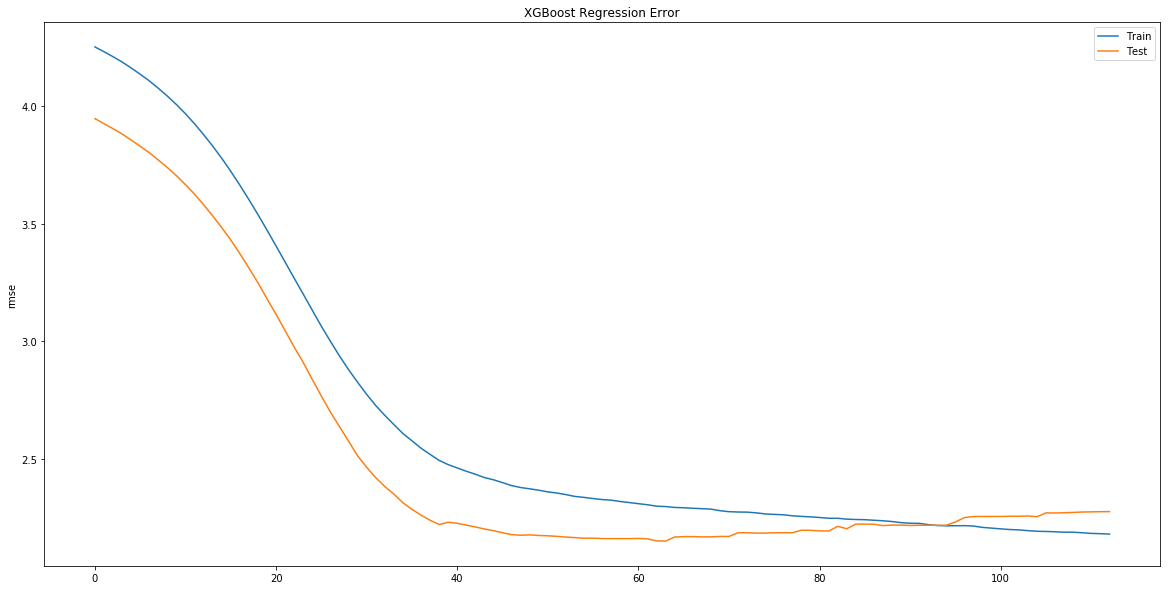


Number of times a feature is used to split the data across all trees:


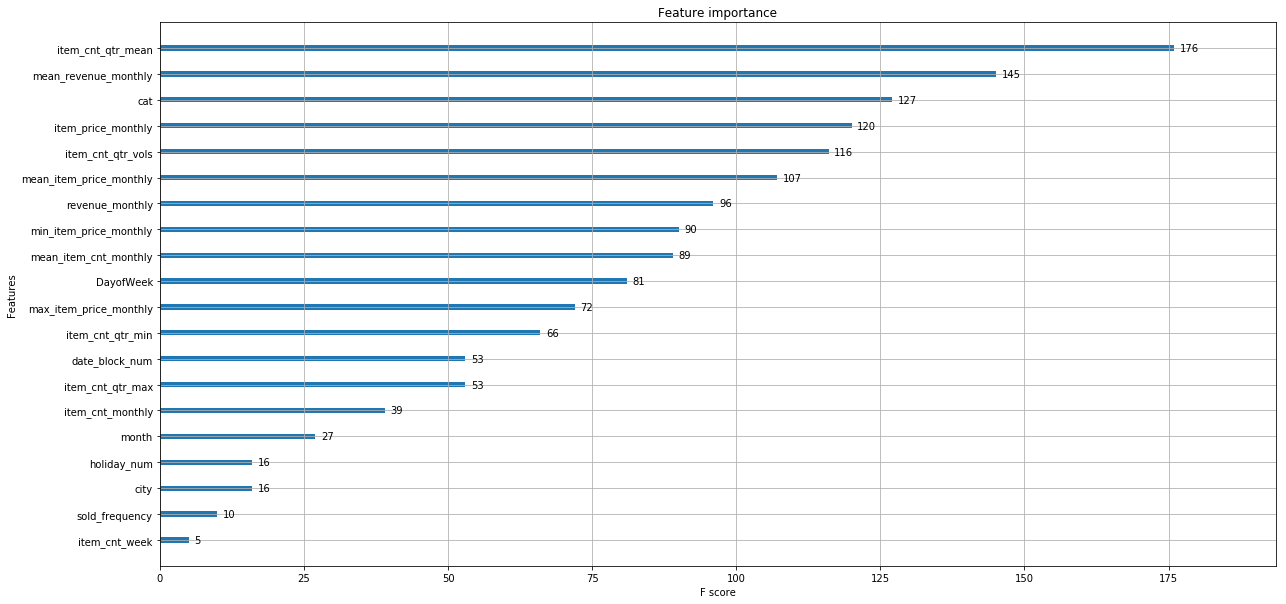


Number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits:


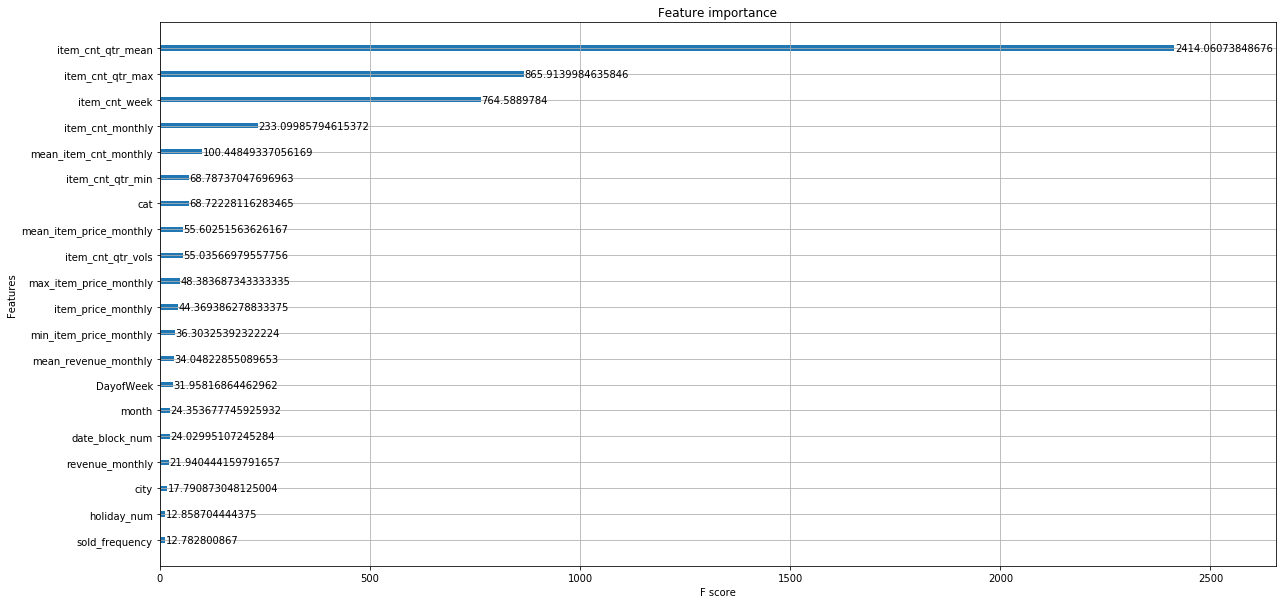


The average training loss reduction gained when using a feature for splitting:


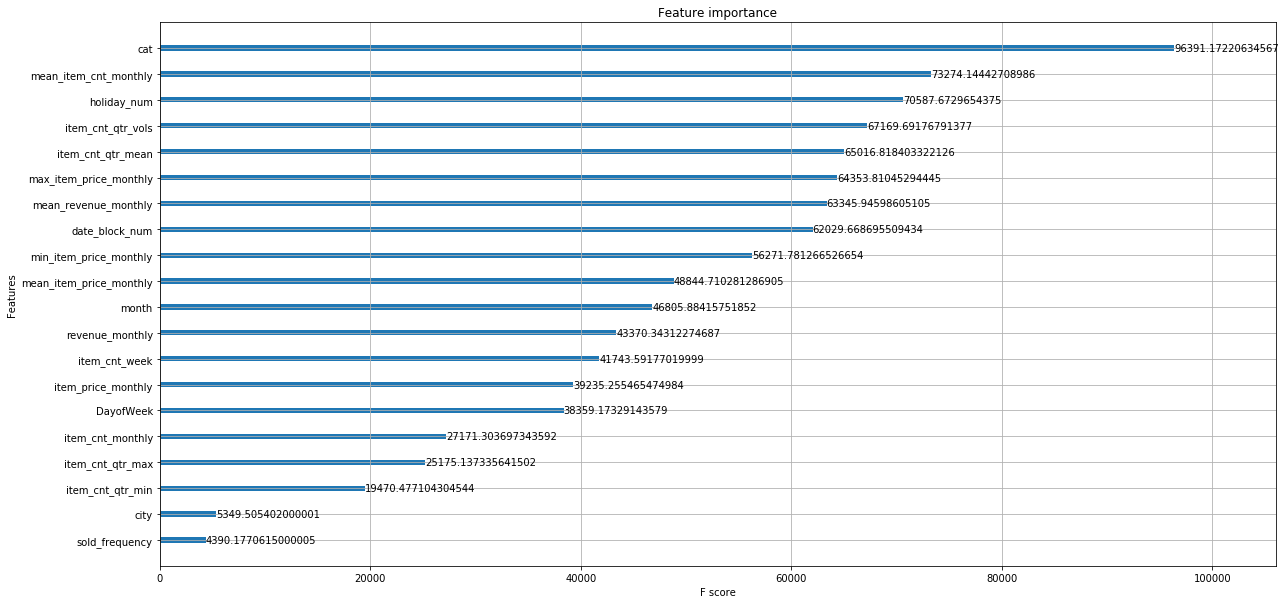


Visualize the trees


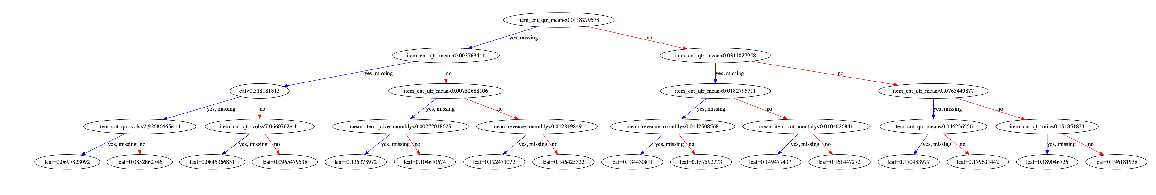

TRAIN: [     0      1      2 ... 333476 333477 333478] TEST: [333479 333480 333481 ... 500214 500215 500216]

        Train data shape: (333479, 21)
        Test data shape: (166738, 21)
        
[0]	validation_0-rmse:4.09504	validation_1-rmse:3.20116
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[20]	validation_0-rmse:3.25918	validation_1-rmse:2.47998
[40]	validation_0-rmse:2.31541	validation_1-rmse:2.08582
[60]	validation_0-rmse:2.19821	validation_1-rmse:2.11434
[80]	validation_0-rmse:2.14937	validation_1-rmse:2.11048
Stopping. Best iteration:
[42]	validation_0-rmse:2.28799	validation_1-rmse:2.08166


        train rmse: 2.2885712541376435
        test rmse: 2.0817520335813176
        train explained variance: 0.6646818312894955
        test explained variance: 0.5436419661114267
        train r2 score: 0.6645148431885977
        test r2 score: 0.5401266552272033

        

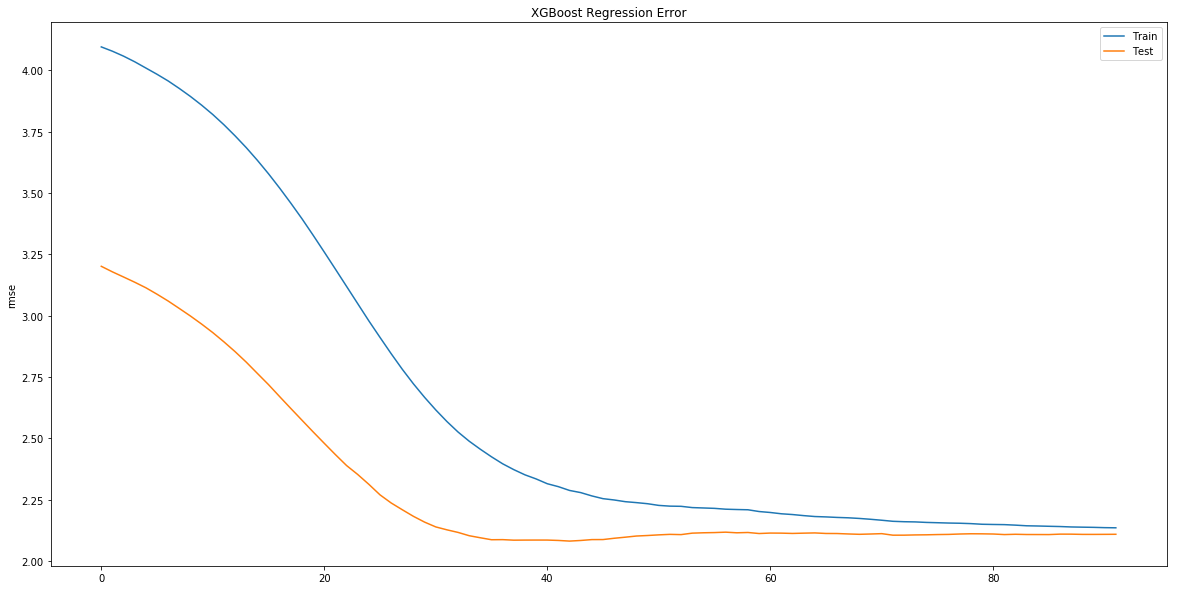


Number of times a feature is used to split the data across all trees:


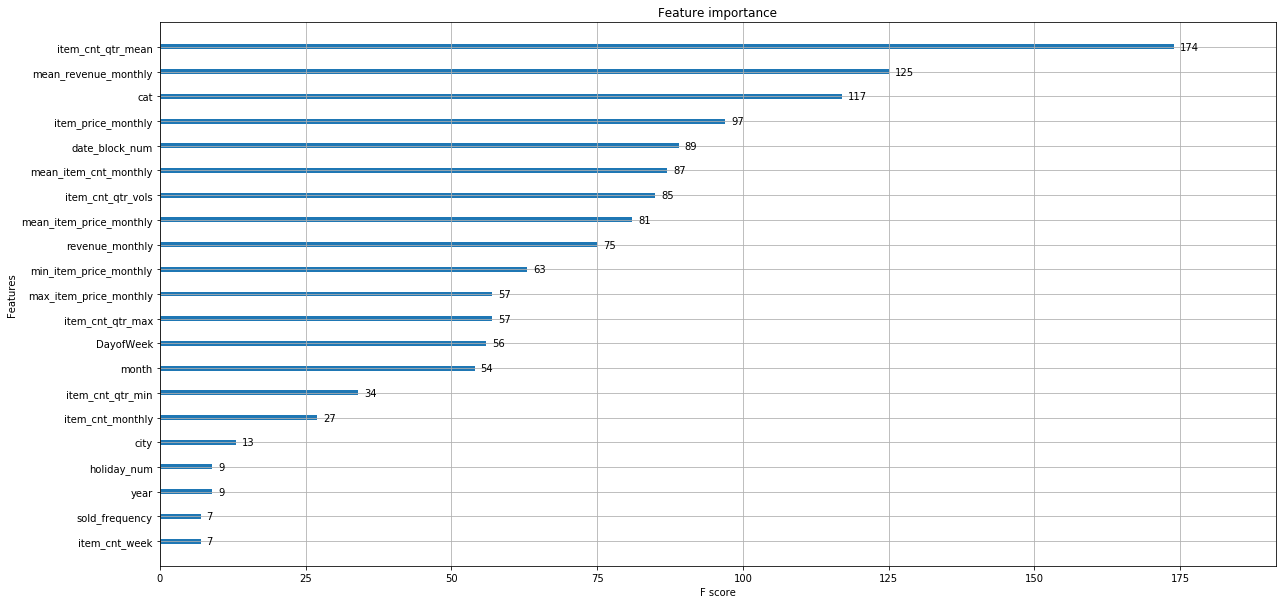


Number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits:


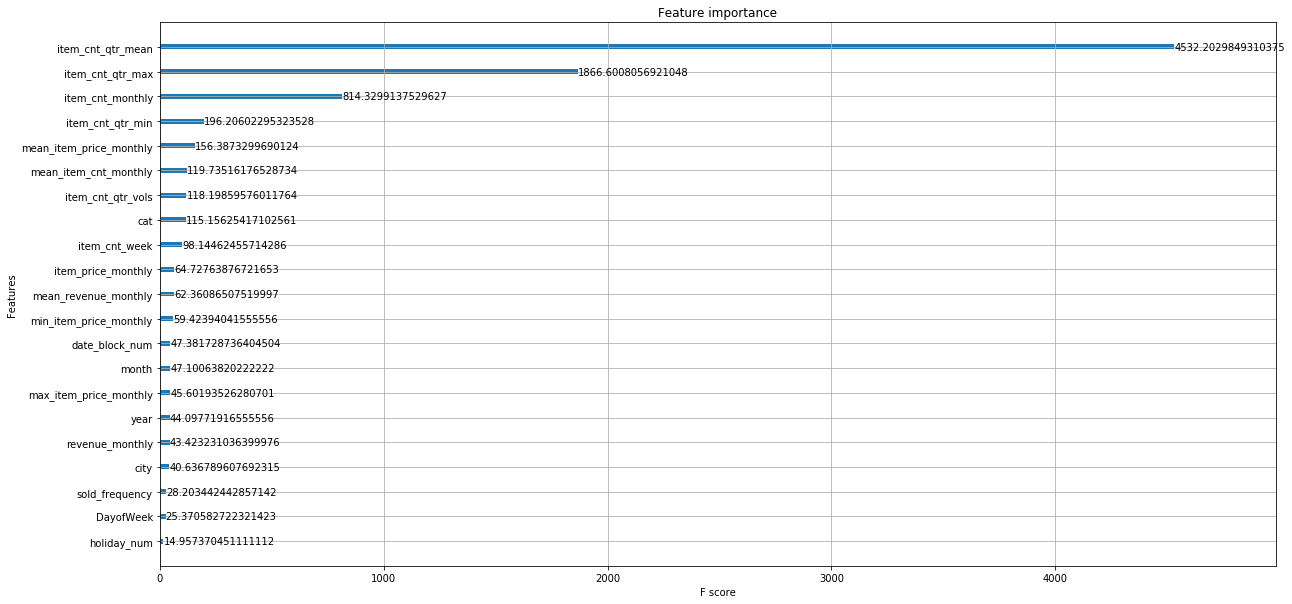


The average training loss reduction gained when using a feature for splitting:


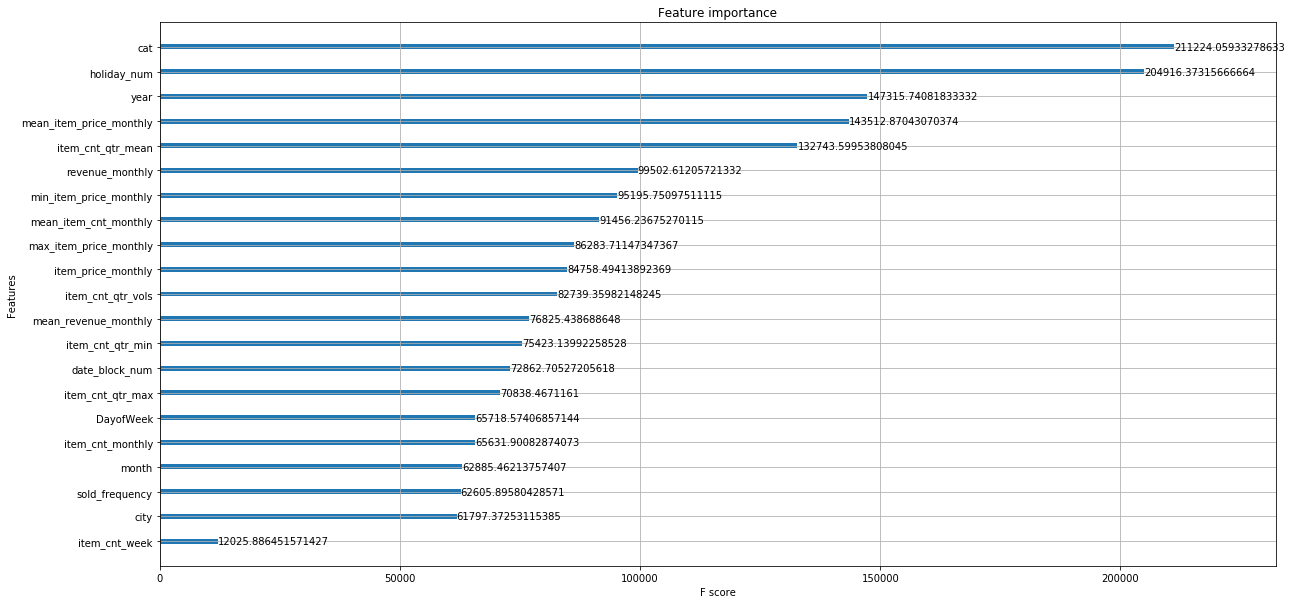


Visualize the trees


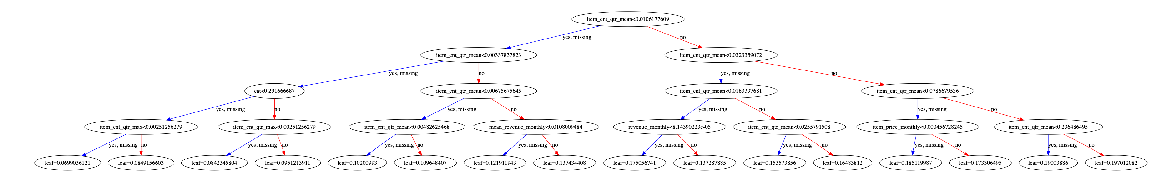

TRAIN: [     0      1      2 ... 500214 500215 500216] TEST: [500217 500218 500219 ... 666952 666953 666954]

        Train data shape: (500217, 21)
        Test data shape: (166738, 21)
        
[0]	validation_0-rmse:3.81336	validation_1-rmse:3.55034
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[20]	validation_0-rmse:3.04162	validation_1-rmse:2.82884
[40]	validation_0-rmse:2.22097	validation_1-rmse:2.15979
[60]	validation_0-rmse:2.12438	validation_1-rmse:2.12179
[80]	validation_0-rmse:2.08726	validation_1-rmse:2.14981
[100]	validation_0-rmse:2.06351	validation_1-rmse:2.17171
Stopping. Best iteration:
[55]	validation_0-rmse:2.13371	validation_1-rmse:2.11186


        train rmse: 2.1345848647813863
        test rmse: 2.1120177830962503
        train explained variance: 0.6639428538000482
        test explained variance: 0.617620920034421
        train r2 score: 0.66391702734

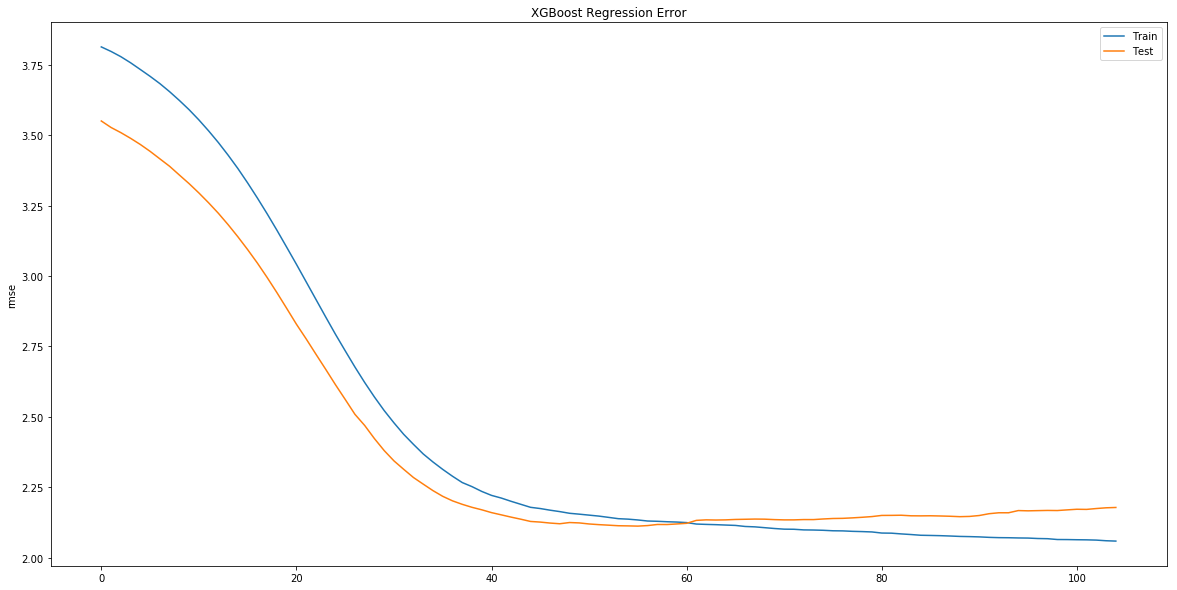


Number of times a feature is used to split the data across all trees:


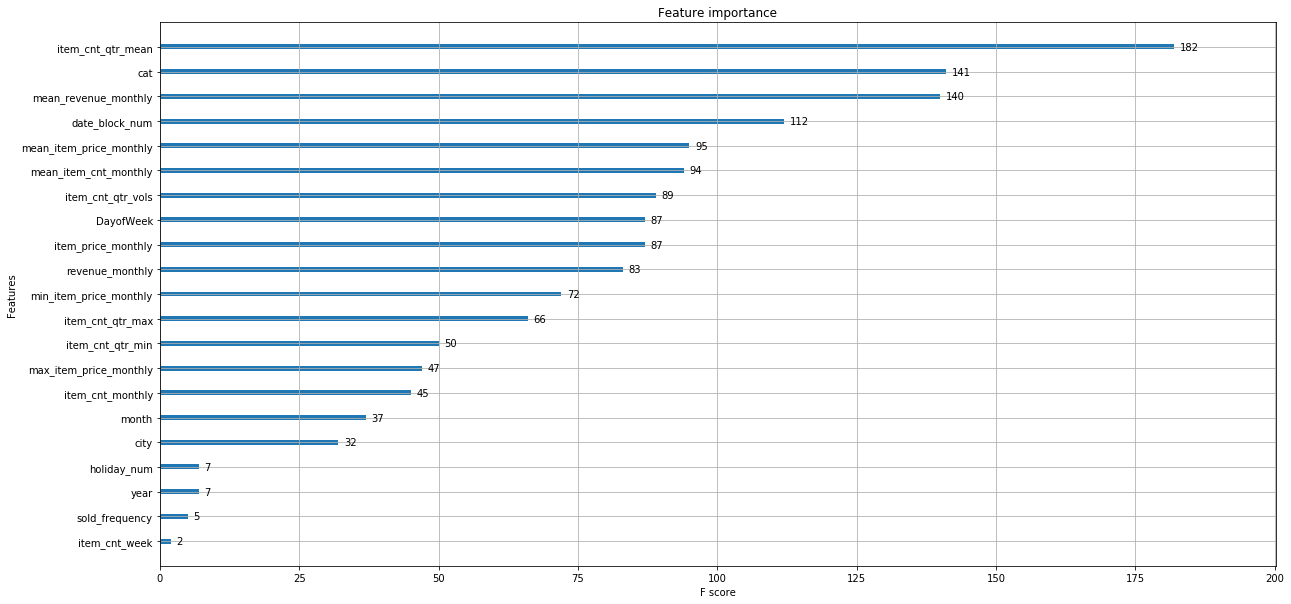


Number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits:


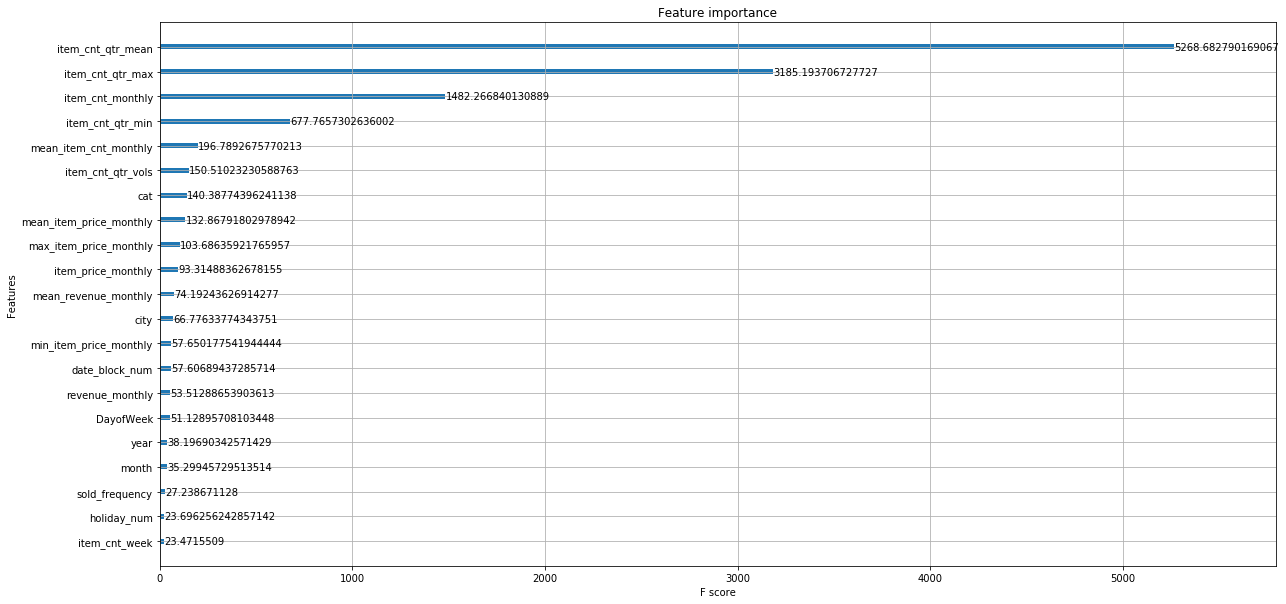


The average training loss reduction gained when using a feature for splitting:


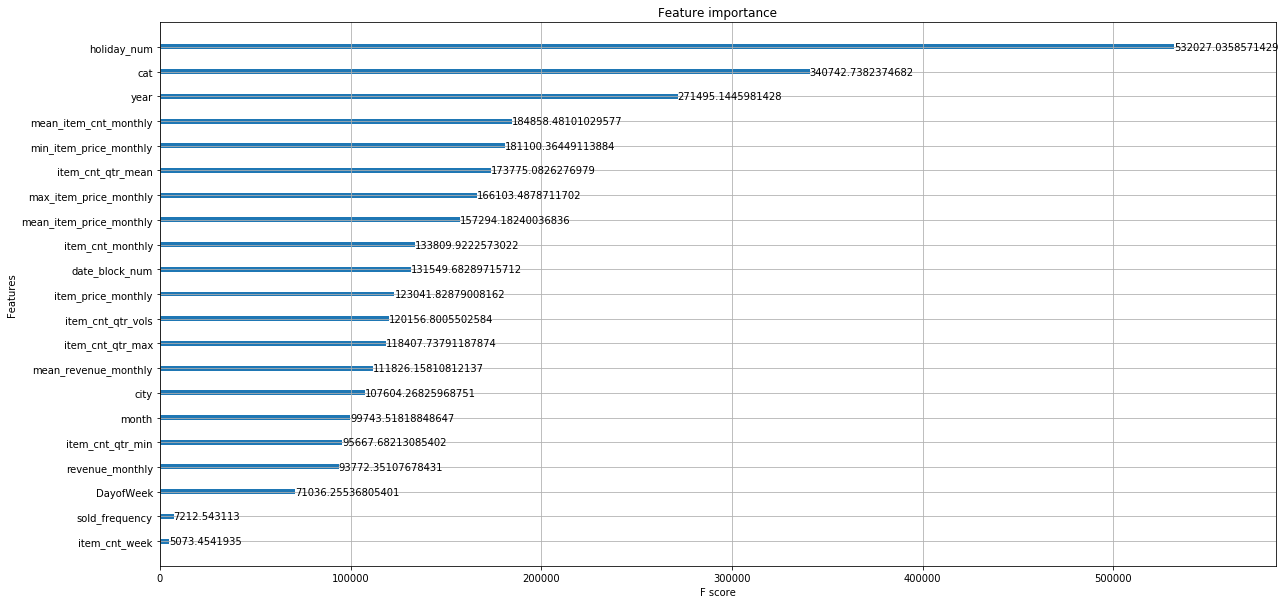


Visualize the trees


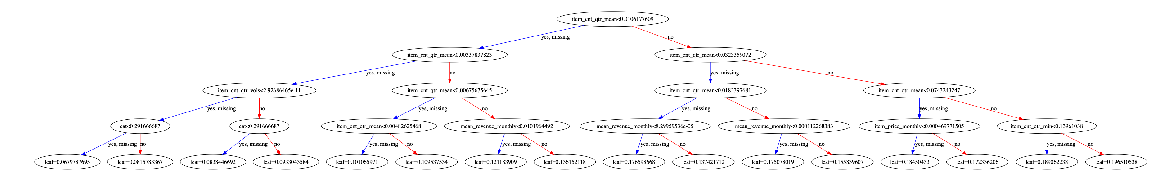

TRAIN: [     0      1      2 ... 666952 666953 666954] TEST: [666955 666956 666957 ... 833690 833691 833692]

        Train data shape: (666955, 21)
        Test data shape: (166738, 21)
        
[0]	validation_0-rmse:3.74348	validation_1-rmse:2.86529
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[20]	validation_0-rmse:2.99033	validation_1-rmse:2.35295
[40]	validation_0-rmse:2.19731	validation_1-rmse:2.15957
[60]	validation_0-rmse:2.10782	validation_1-rmse:2.18078
[80]	validation_0-rmse:2.08215	validation_1-rmse:2.18428
Stopping. Best iteration:
[35]	validation_0-rmse:2.28433	validation_1-rmse:2.14895


        train rmse: 2.2857194011864532
        test rmse: 2.1491226201508433
        train explained variance: 0.6011692256945224
        test explained variance: 0.39917778800911097
        train r2 score: 0.6006639022938708
        test r2 score: 0.39702903116037935

      

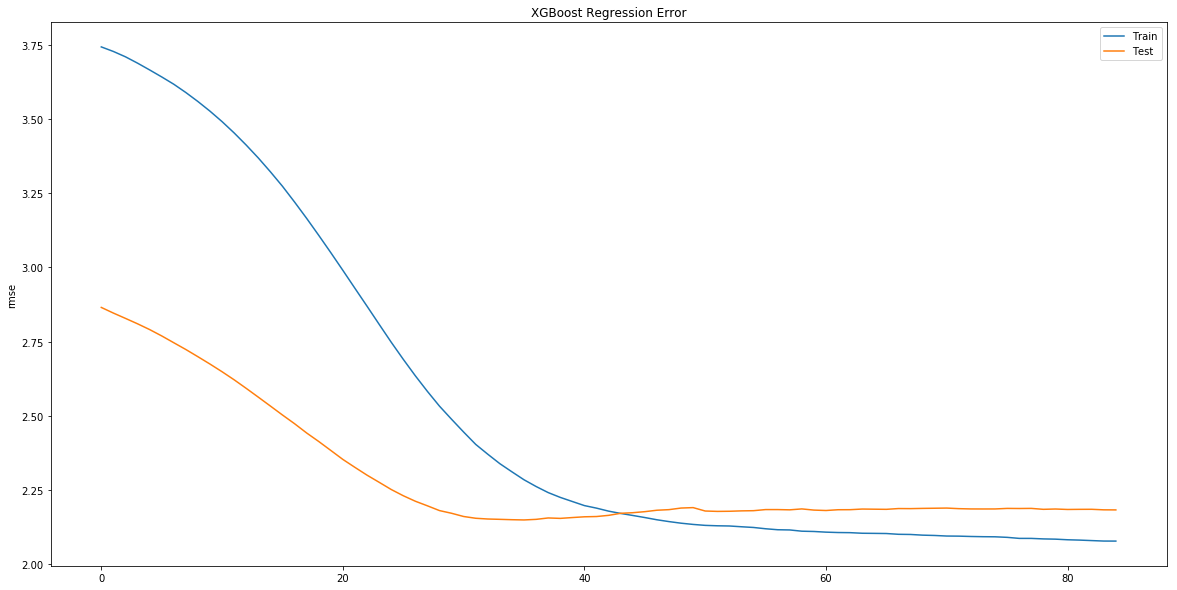


Number of times a feature is used to split the data across all trees:


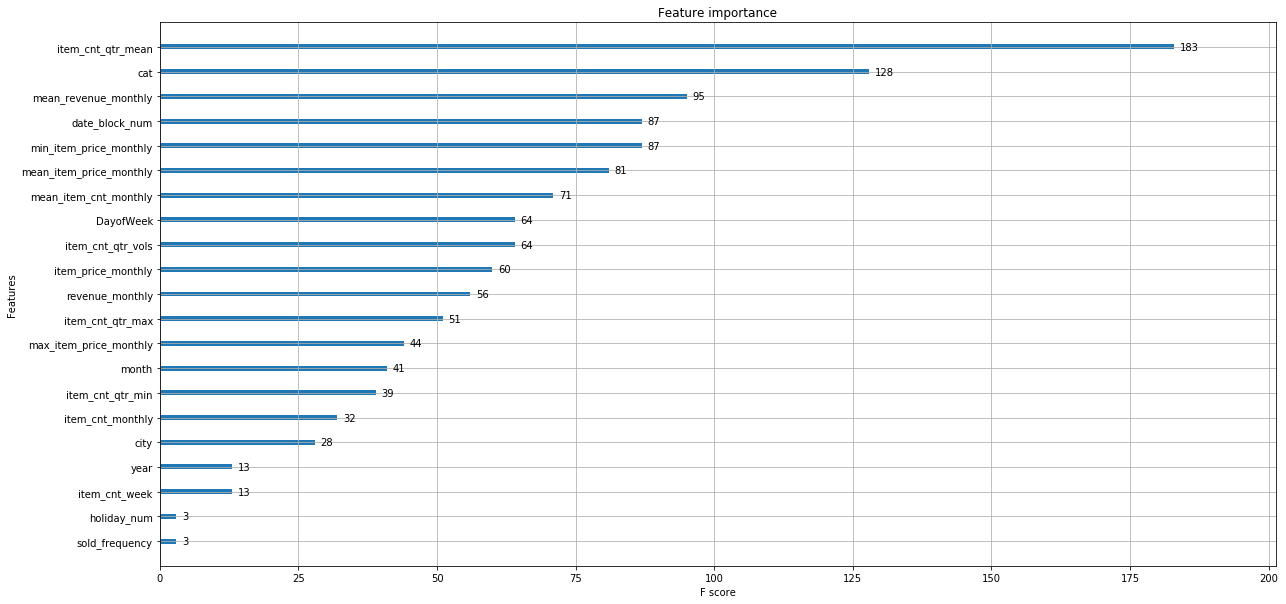


Number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits:


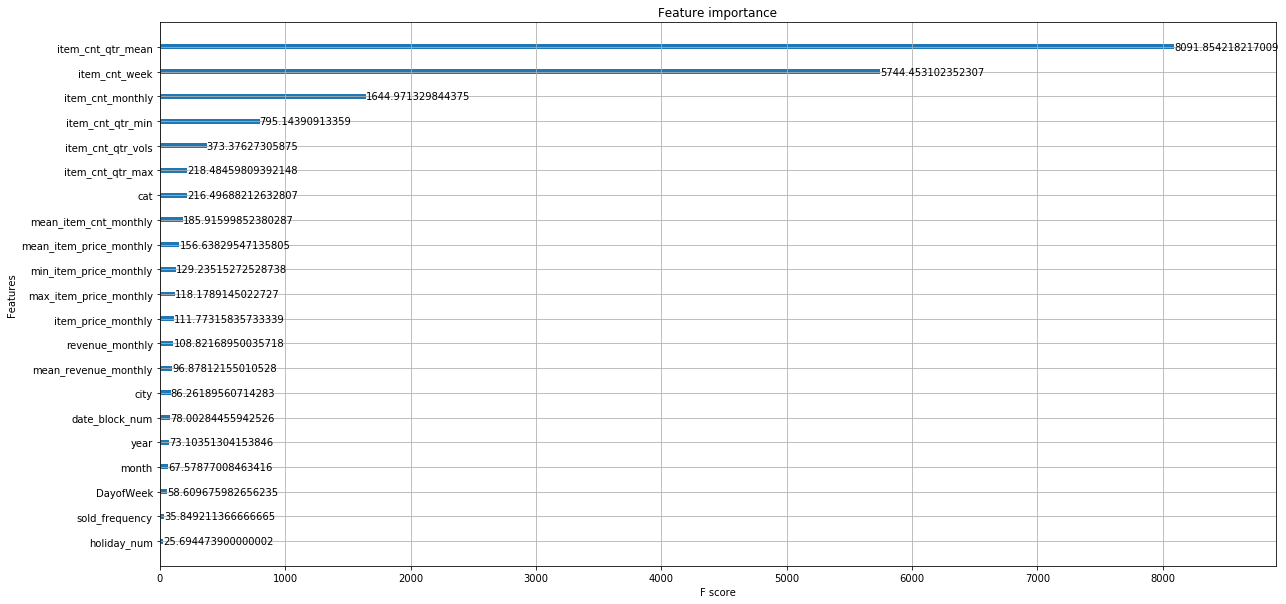


The average training loss reduction gained when using a feature for splitting:


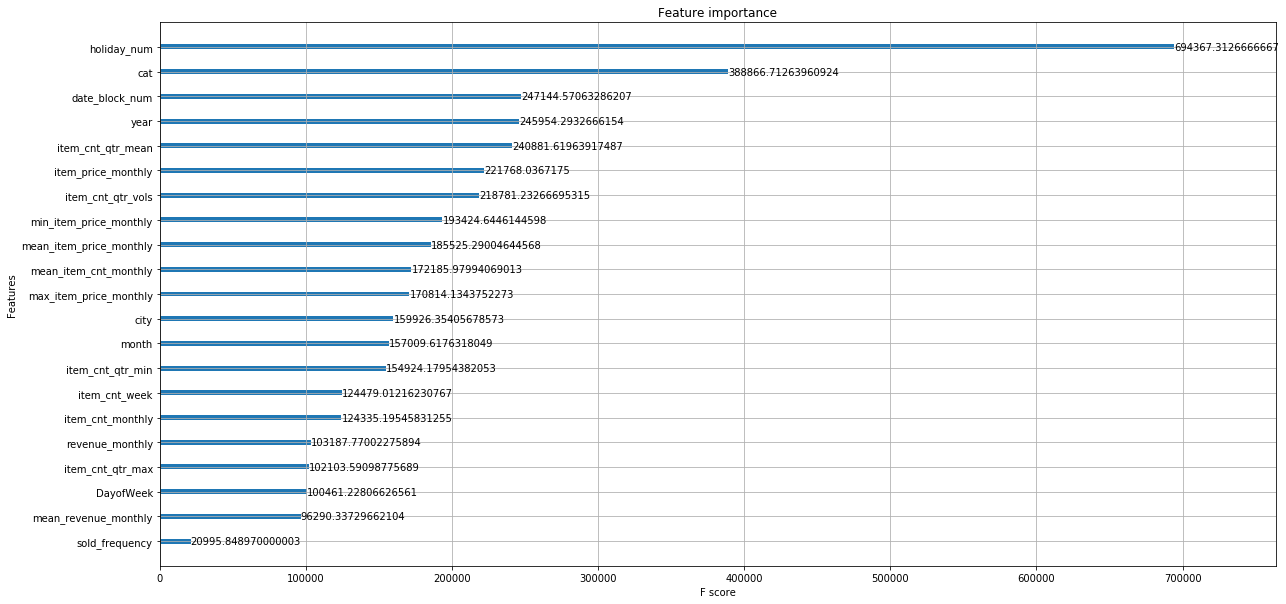


Visualize the trees


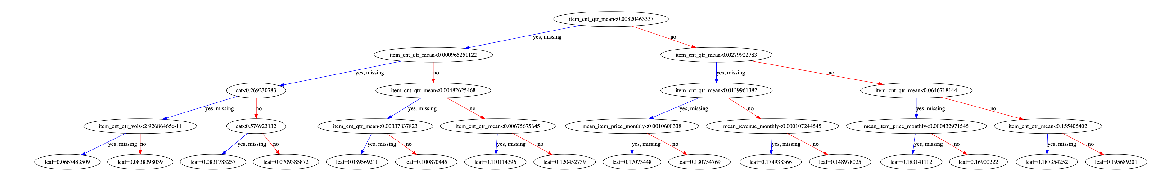

TRAIN: [     0      1      2 ... 833690 833691 833692] TEST: [ 833693  833694  833695 ... 1000428 1000429 1000430]

        Train data shape: (833693, 21)
        Test data shape: (166738, 21)
        
[0]	validation_0-rmse:3.57978	validation_1-rmse:2.12986
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[20]	validation_0-rmse:2.88225	validation_1-rmse:1.70821
[40]	validation_0-rmse:2.19516	validation_1-rmse:1.69801
[60]	validation_0-rmse:2.10887	validation_1-rmse:1.75156
Stopping. Best iteration:
[27]	validation_0-rmse:2.52086	validation_1-rmse:1.60054


        train rmse: 2.5219133595117977
        test rmse: 1.6007126246845707
        train explained variance: 0.4724258848467242
        test explained variance: 0.4682477572647844
        train r2 score: 0.47047591145719614
        test r2 score: 0.419211183135364

        


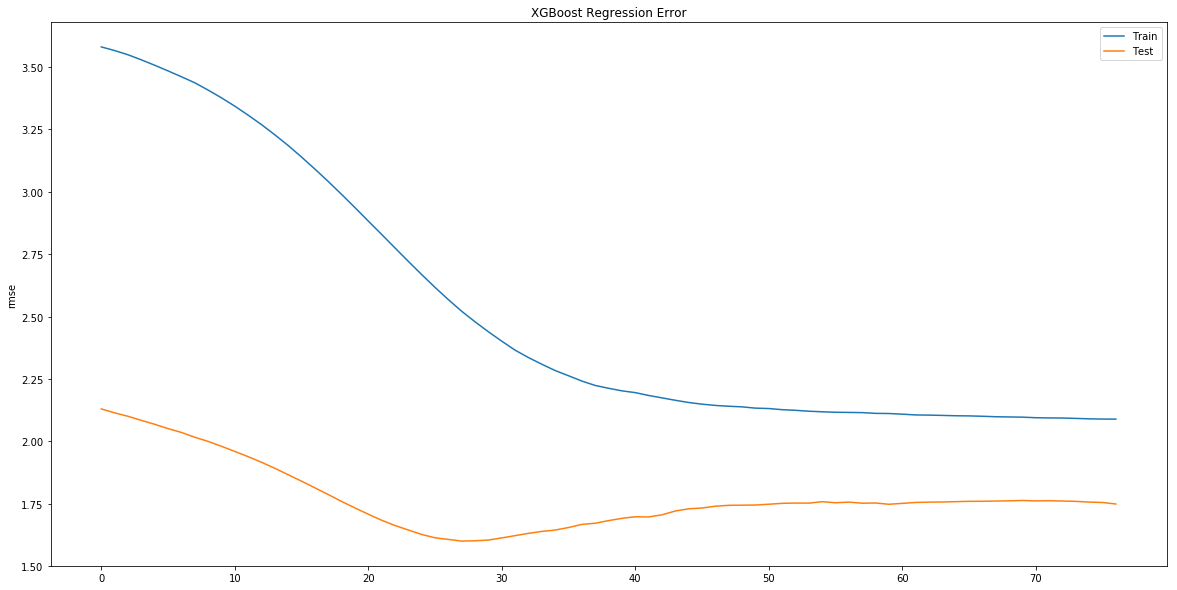


Number of times a feature is used to split the data across all trees:


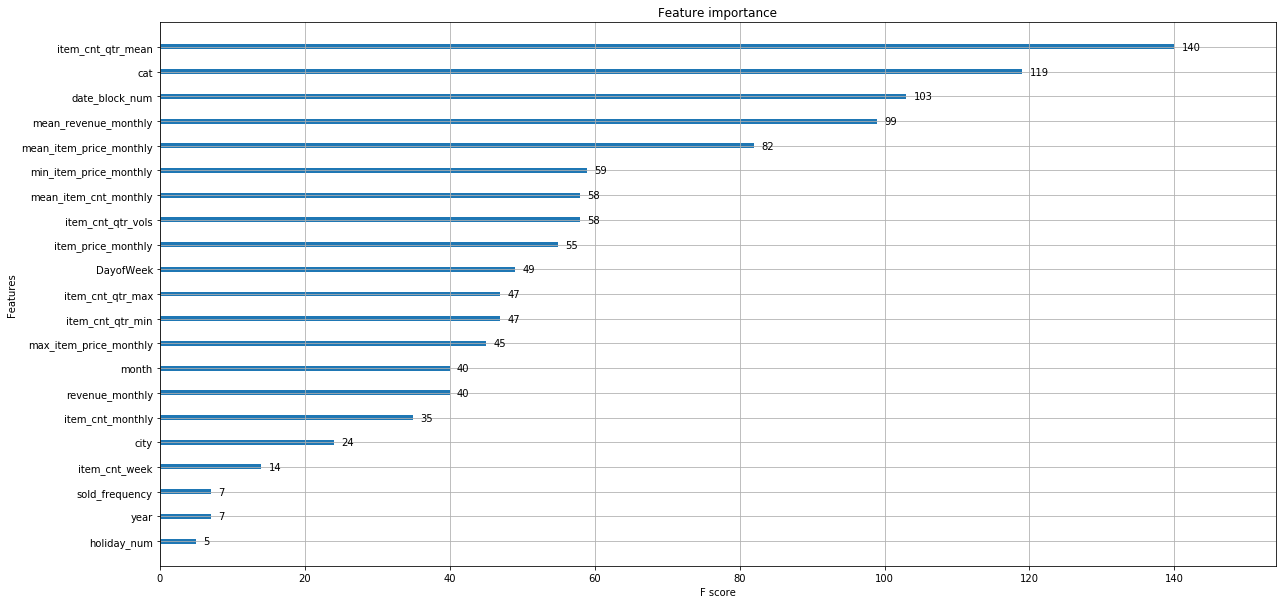


Number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits:


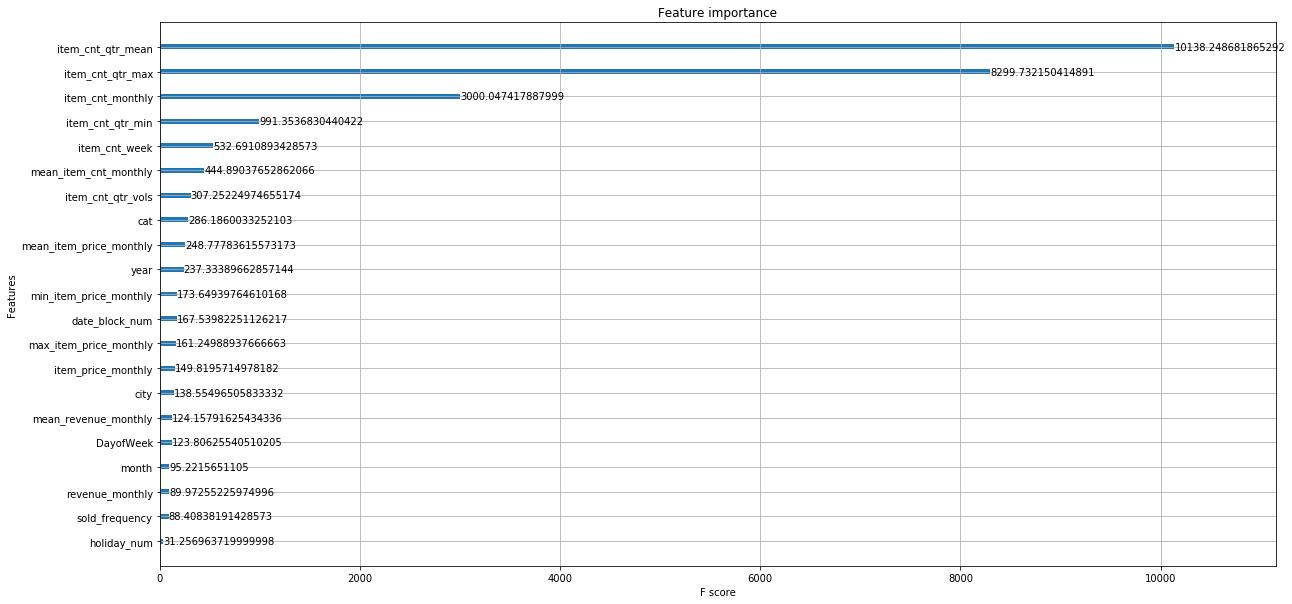


The average training loss reduction gained when using a feature for splitting:


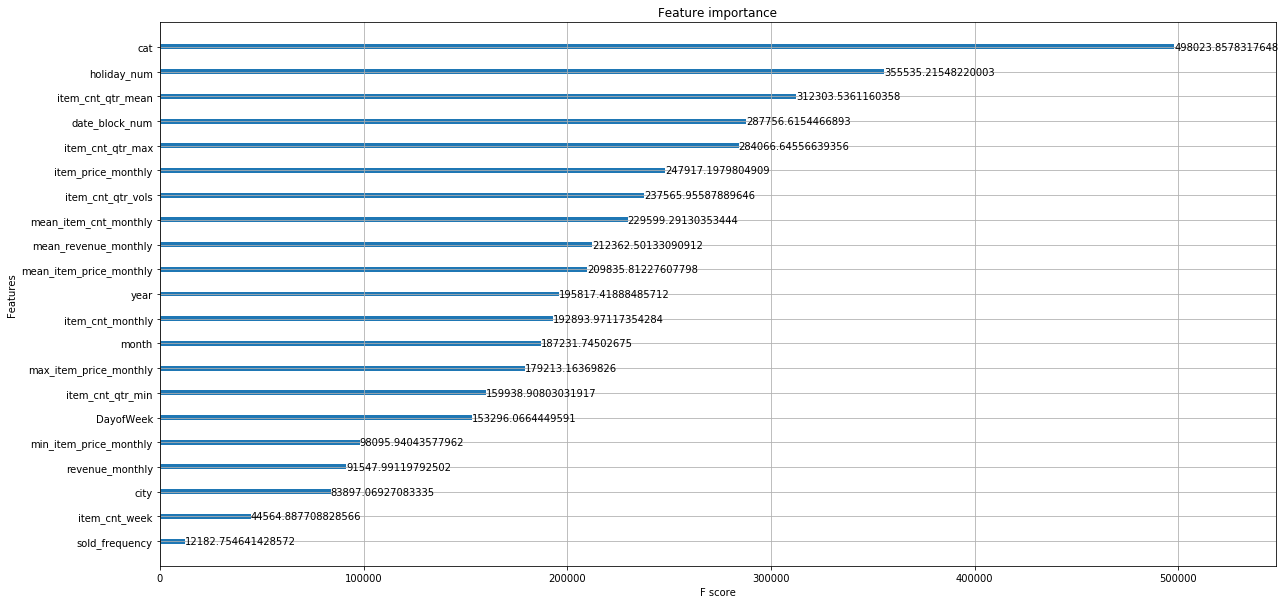


Visualize the trees


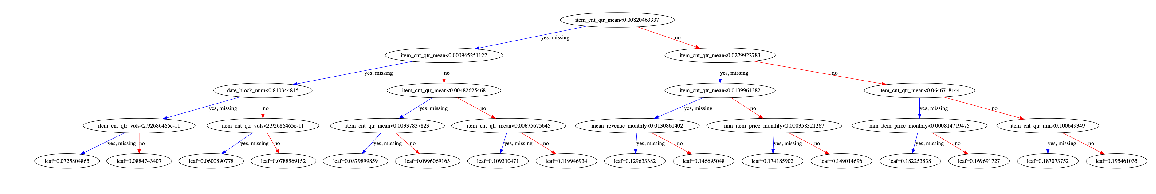

array([0.9965738, 1.3020288, 0.9965738, ..., 1.198573 , 1.0163724,
       1.0381297], dtype=float32)

In [111]:
# data to be implemented
train_final_monthly_m = train_final_monthly_final.copy()

# traning, testing, and reporting
m = model_pipline(train_final_monthly_m, 5)
m


### 3.6 - (Extra I) Concentrate on one shop_id
Anthoer model to see how the model perform on specific store (shop_id).

we choose shop_id: 31, the highest number of items sold per store identified in the EDA.

As we just simply wonder how the model train on specific store, we split 2 time series for our train and test set in this case.


TRAIN: [    0     1     2 ... 27569 27570 27571] TEST: [27572 27573 27574 ... 55140 55141 55142]

        Train data shape: (27572, 21)
        Test data shape: (27571, 21)
        
[0]	validation_0-rmse:6.8859	validation_1-rmse:5.45204
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[20]	validation_0-rmse:5.64709	validation_1-rmse:4.31027
[40]	validation_0-rmse:2.77779	validation_1-rmse:2.4106
[60]	validation_0-rmse:2.29788	validation_1-rmse:2.4732
[80]	validation_0-rmse:2.21522	validation_1-rmse:2.53807
Stopping. Best iteration:
[41]	validation_0-rmse:2.72587	validation_1-rmse:2.40396


        train rmse: 2.7259001212883547
        test rmse: 2.403978564681101
        train explained variance: 0.8356569324598871
        test explained variance: 0.7940361437875648
        train r2 score: 0.8353862500219655
        test r2 score: 0.7939694015328155

        


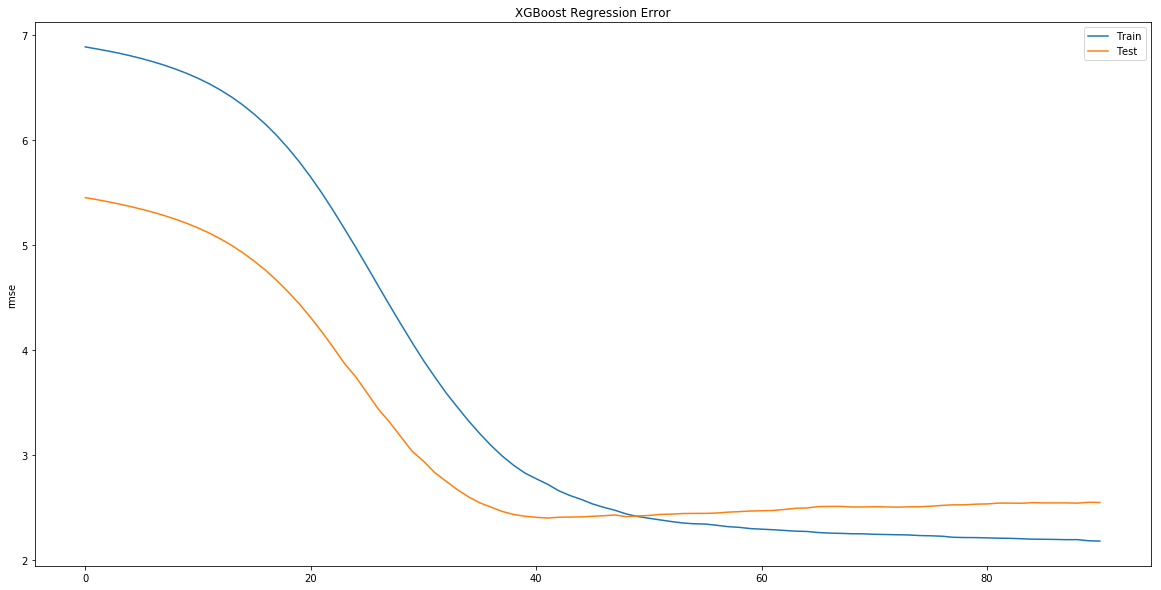


Number of times a feature is used to split the data across all trees:


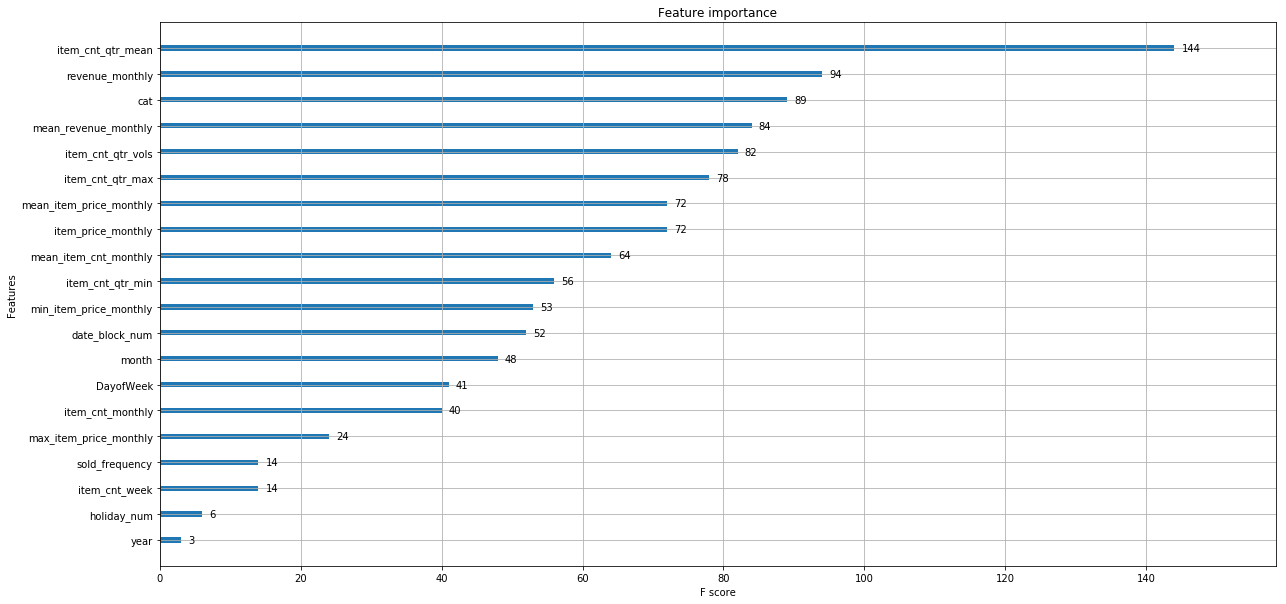


Number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits:


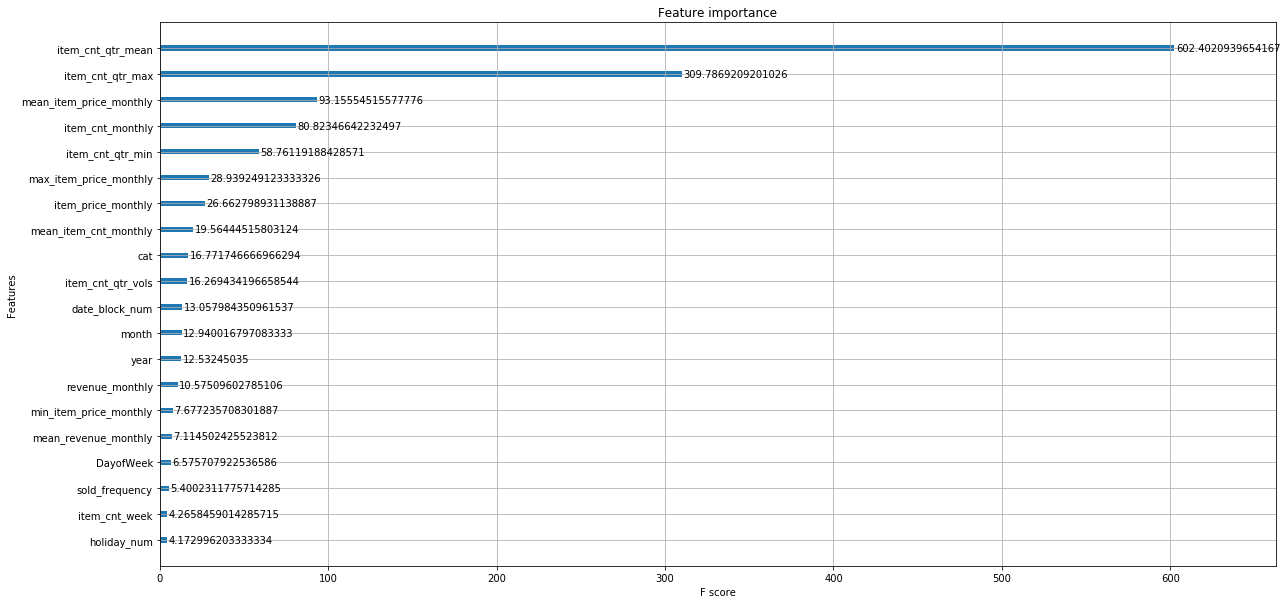


The average training loss reduction gained when using a feature for splitting:


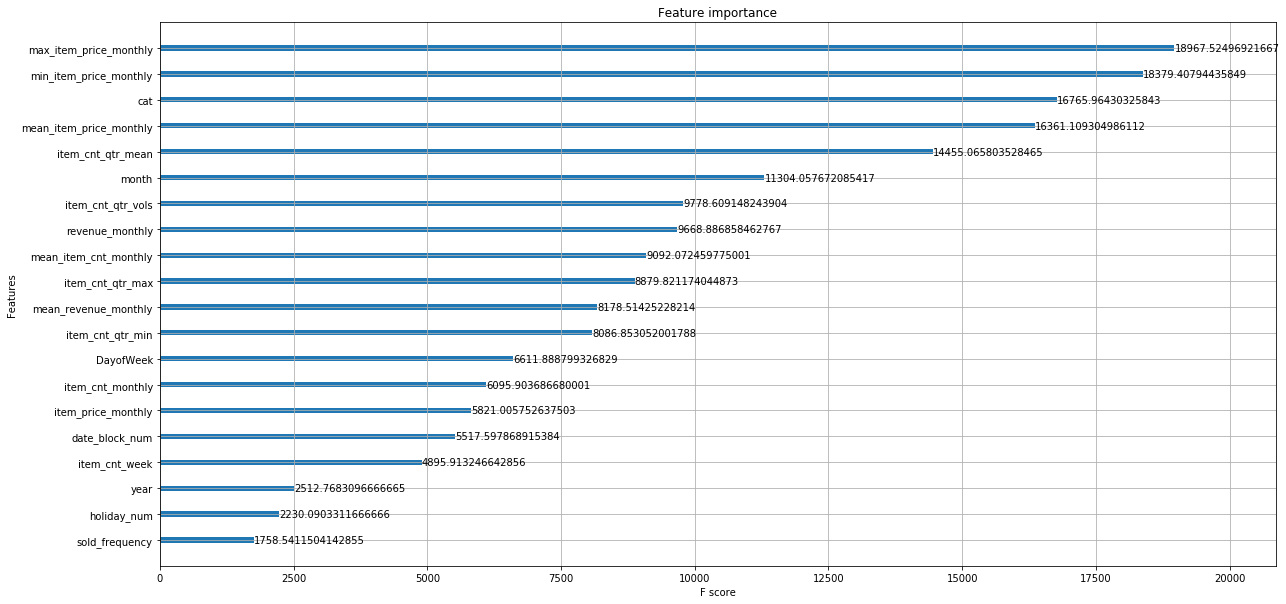


Visualize the trees


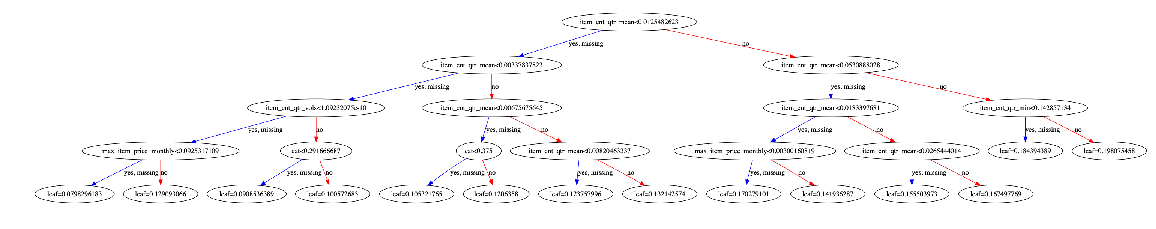

array([1.1284596, 1.1284596, 1.2609253, ..., 2.0152354, 1.6498634,
       1.8813661], dtype=float32)

In [100]:
# data to be implemented
train_final_monthly_m_31 = train_final_monthly_final[train_final_monthly_final.shop_id == 31]
train_final_monthly_m_31.tail()

# traning, testing, and reporting
m_31 = model_pipline(train_final_monthly_m_31, 2)
m_31


##### Findings & Future Suggestions:

If we only train the model on one shop (here we select the shop_id 31 based on our EDA suggestions, which is the store that sells the most item per month), our overall train and test accuracy improve significantly (from highest of ~68% to ~84%). 

This results could suggest a better way to train the model, such that we train on each shop_id rather than the entire train data. This could help us improve the predictions of the individual items sold at store levels in our future study. Moreover, the computation can be less burdan if we do not train on entire dataset.


### 3.7 - (Extra II) Concentrate on using lag_1 information 

lag_1 means test month item sold = prior month item solds.

Anthoer model to see how the model perform, using the lag_1 time series information. The test set will set to be a lag 1 infomration.

Again, as we just simply wonder how the model train on specific store, for example, we split 2 time series for our train and test set in this section.


TRAIN: [     0      1      2 ... 333474 333475 333476] TEST: [333477 333478 333479 ... 666951 666952 666953]

        Train data shape: (333477, 22)
        Test data shape: (333477, 22)
        
[0]	validation_0-rmse:4.09504	validation_1-rmse:3.38127
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[20]	validation_0-rmse:3.23743	validation_1-rmse:2.65599
[40]	validation_0-rmse:2.23287	validation_1-rmse:2.0302
[60]	validation_0-rmse:2.09255	validation_1-rmse:1.99899
[80]	validation_0-rmse:2.05423	validation_1-rmse:1.99792
[100]	validation_0-rmse:2.02117	validation_1-rmse:2.00089
[120]	validation_0-rmse:1.99731	validation_1-rmse:2.00064
Stopping. Best iteration:
[84]	validation_0-rmse:2.04765	validation_1-rmse:1.99522


        train rmse: 2.048348924759086
        test rmse: 1.9957279582702154
        train explained variance: 0.731254653228861
        test explained variance: 

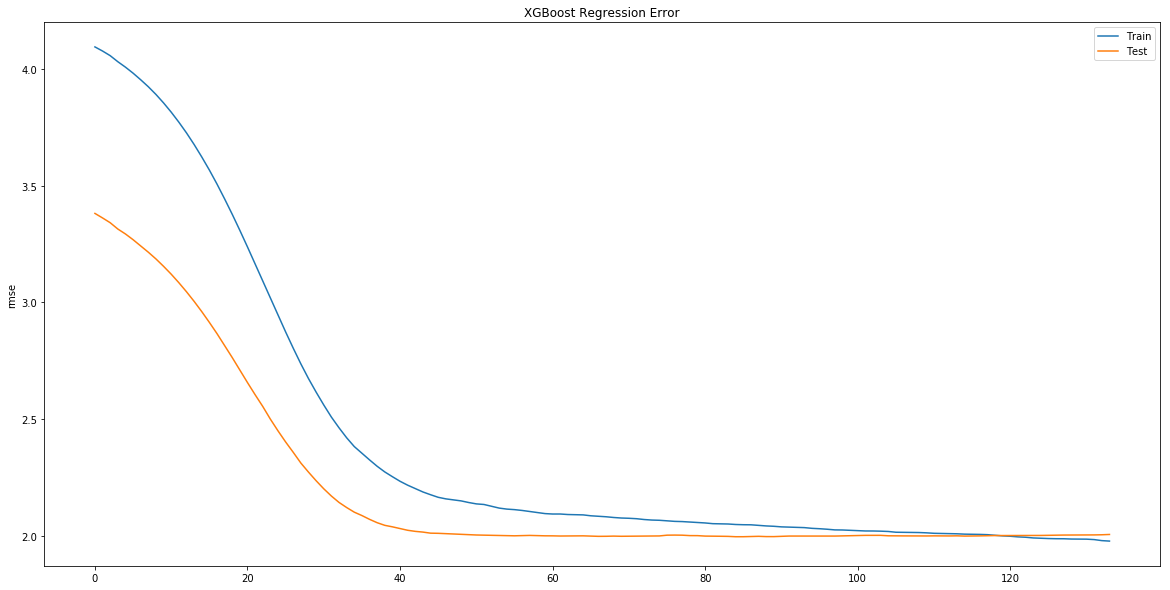


Number of times a feature is used to split the data across all trees:


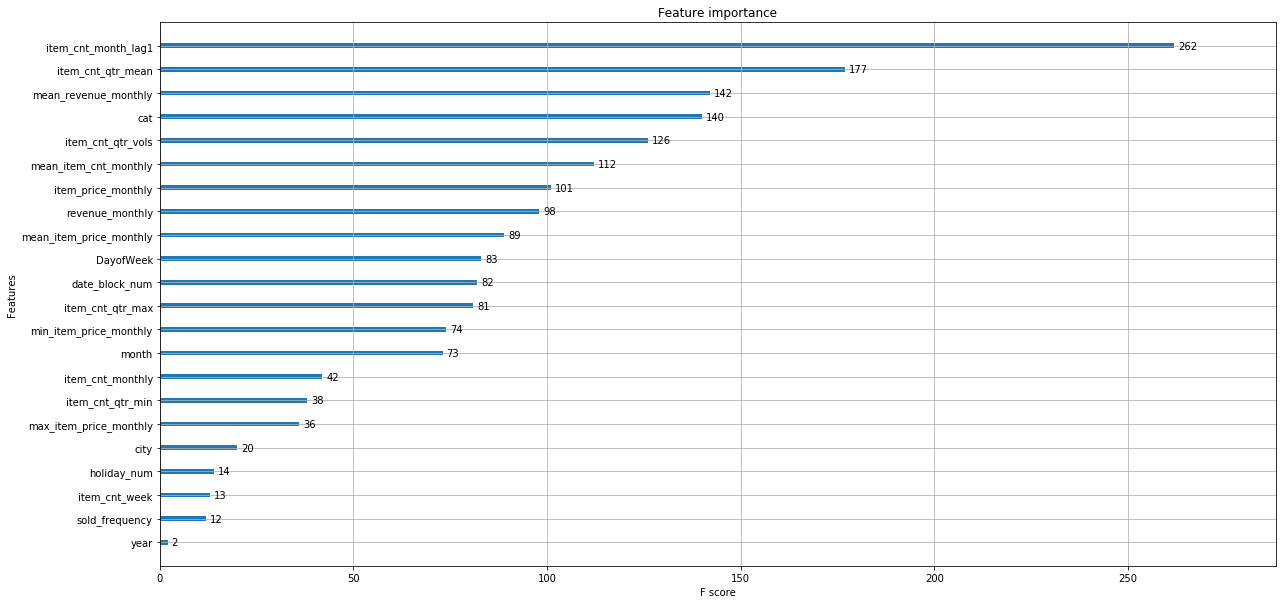


Number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits:


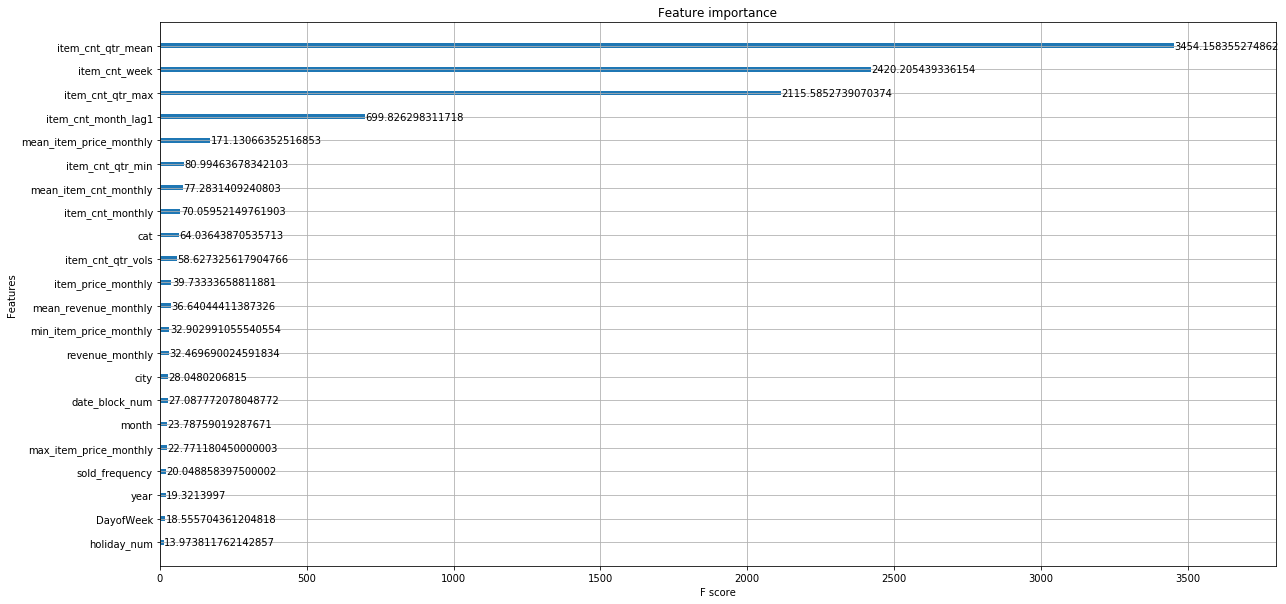


The average training loss reduction gained when using a feature for splitting:


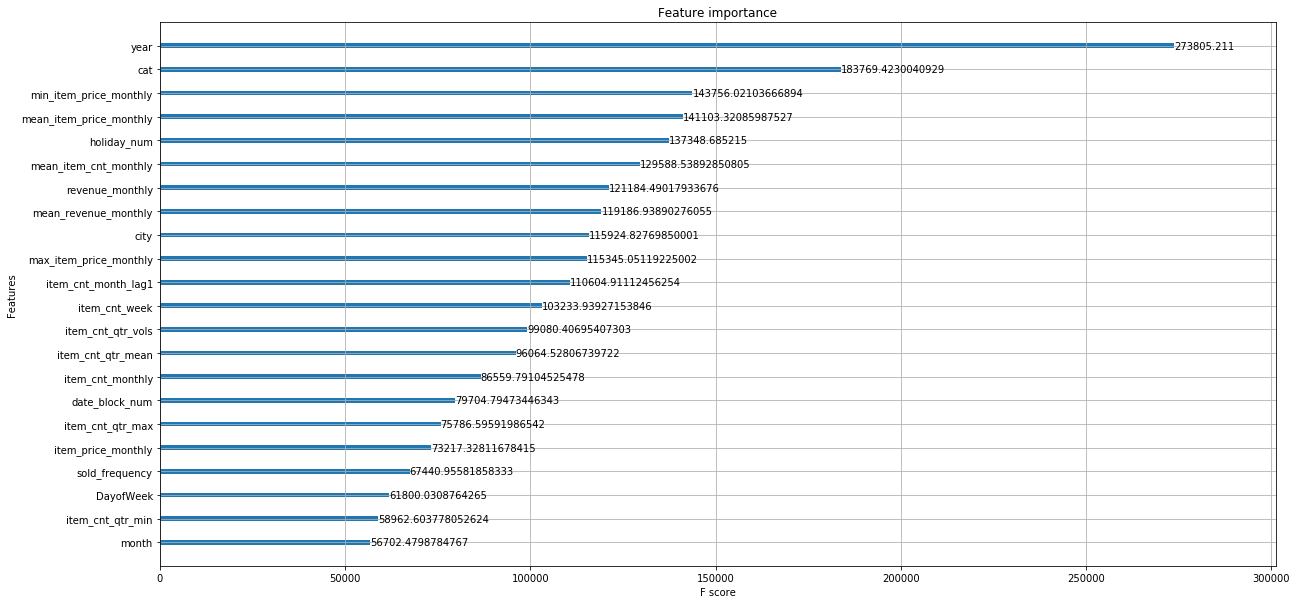


Visualize the trees


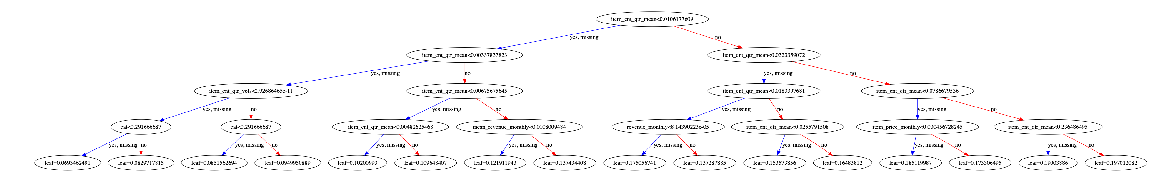

TRAIN: [     0      1      2 ... 666951 666952 666953] TEST: [ 666954  666955  666956 ... 1000428 1000429 1000430]

        Train data shape: (666954, 22)
        Test data shape: (333477, 22)
        
[0]	validation_0-rmse:3.74325	validation_1-rmse:2.52522
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[20]	validation_0-rmse:2.96877	validation_1-rmse:2.01278
[40]	validation_0-rmse:2.12819	validation_1-rmse:1.77531
[60]	validation_0-rmse:2.03261	validation_1-rmse:1.77314
[80]	validation_0-rmse:1.99747	validation_1-rmse:1.76977
[100]	validation_0-rmse:1.97791	validation_1-rmse:1.76432
[120]	validation_0-rmse:1.96181	validation_1-rmse:1.76747
[140]	validation_0-rmse:1.94639	validation_1-rmse:1.76821
[160]	validation_0-rmse:1.92809	validation_1-rmse:1.76838
Stopping. Best iteration:
[110]	validation_0-rmse:1.97117	validation_1-rmse:1.76151


        train rmse: 1.972690443719745

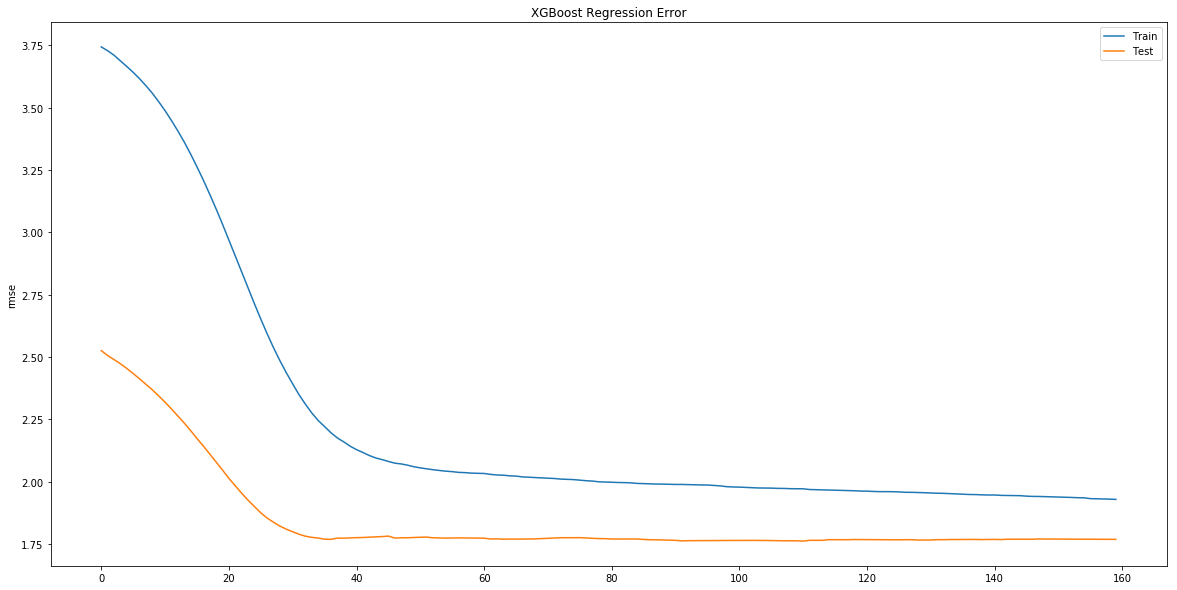


Number of times a feature is used to split the data across all trees:


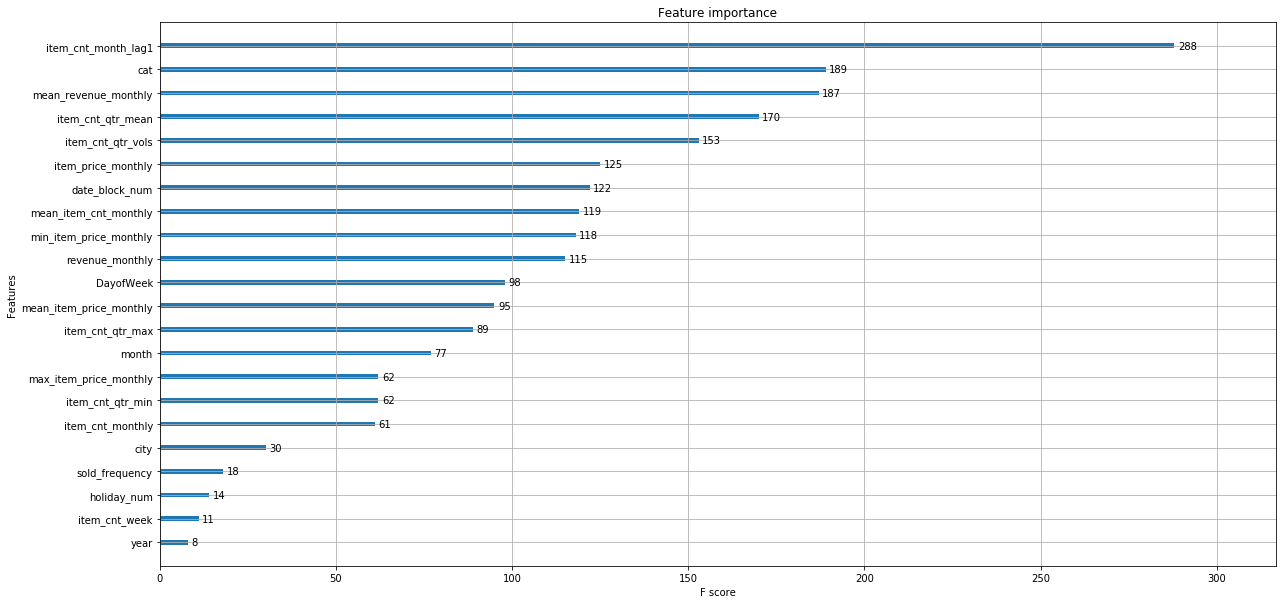


Number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits:


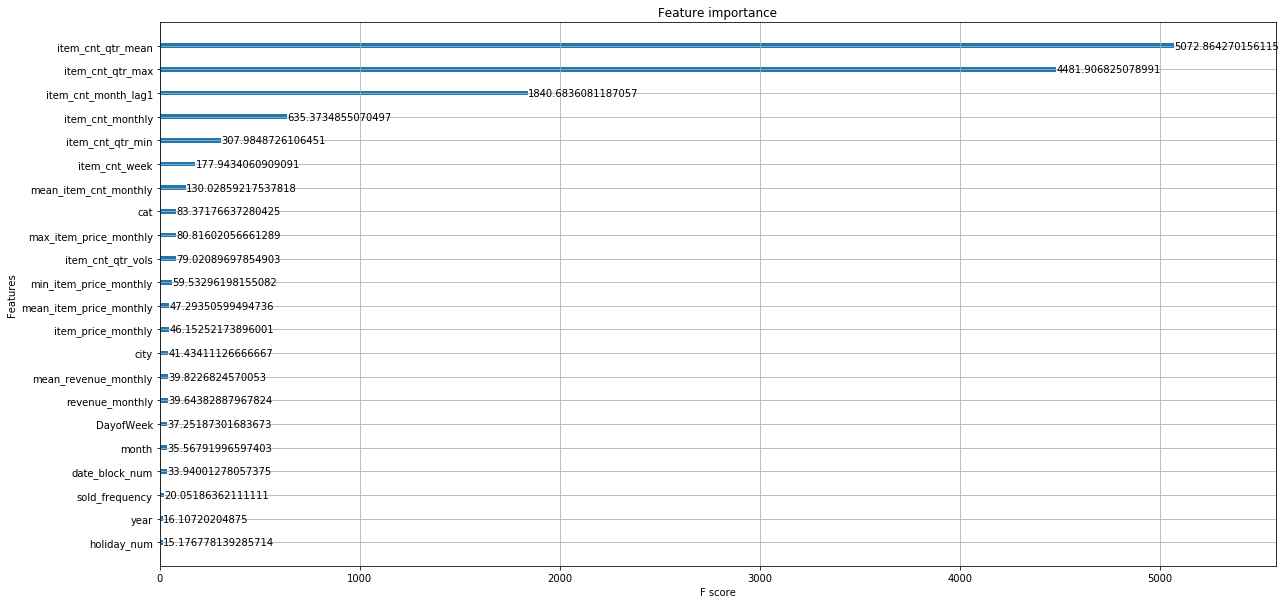


The average training loss reduction gained when using a feature for splitting:


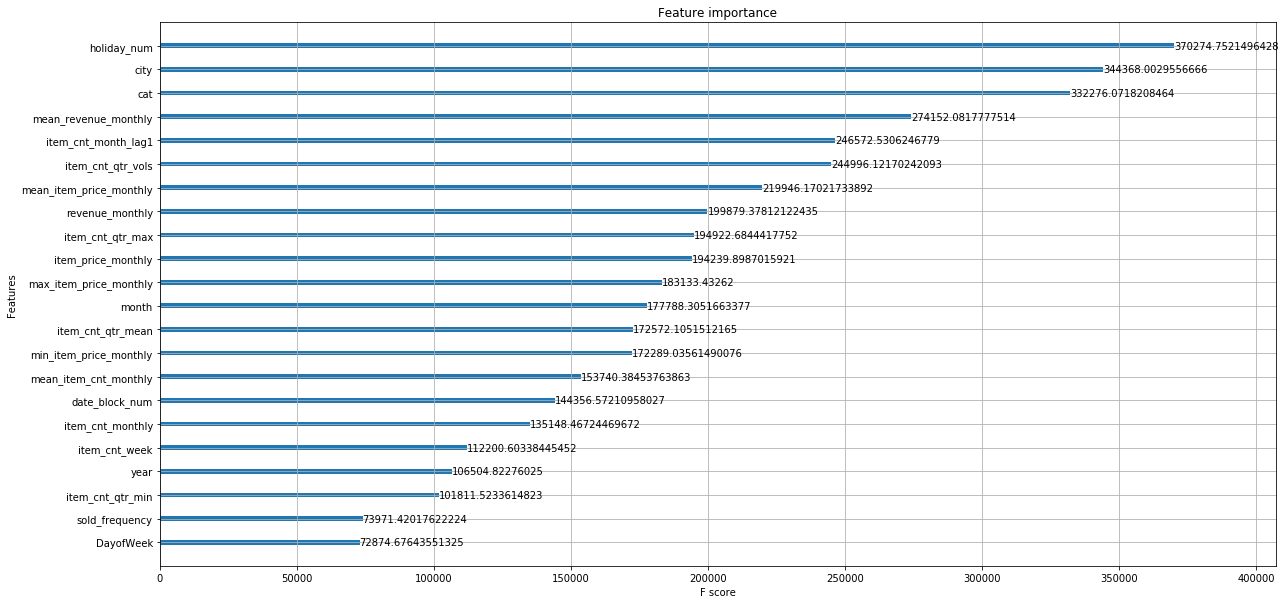


Visualize the trees


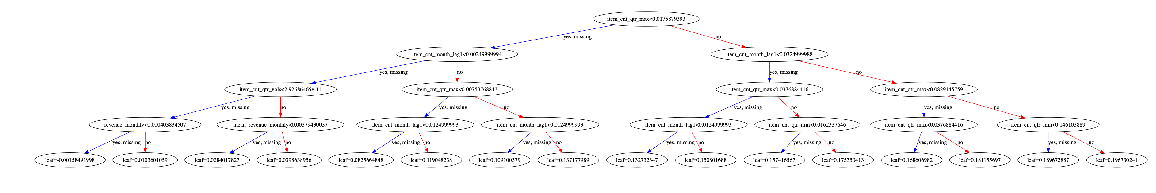

In [67]:
# create data to be implemented
train_final_monthly_m_lag1 = train_final_monthly_final.copy()

# shift -1 meaning X_t-1, so later when we fit the model, the outcome is Y_t already(next month)
train_final_monthly_m_lag1['item_cnt_month_lag1'] = train_final_monthly_m_lag1 \
                                            .sort_values('date_block_num') \
                                            .groupby(['shop_id', 'item_id'])['item_cnt_month'] \
                                            .shift(-1)
# fill nan with 0
train_final_monthly_m_lag1['item_cnt_month_lag1'].fillna(0, inplace=True) 

# traning, testing, and reporting
m_lag_1 = model_pipline(train_final_monthly_m_lag1, 2)
m_lag_1


##### Findings & Suggestions:

As a result, we noticed lag 1 information indeed influence the outputs. There exists autoregressive term in our time series data and affect the model outputs. A suggestion to improve our model is to test the differnet lag and add self-explanatory variable as one of our model features. Perhaps also to look at auto correlation function or partial auto correlation function to chosse the autoregressive process. This practice could be extented in our future study.


# 4 - Optimzation
### Fine-tuned the hyper-parameters (gridsearch) -----------------

In our study, we select smaller dataset to run gridsearch. The re-sampling process is debatable and we ended up extracting samples based on our EDA that we focus on the store where they sells the most items.

**helper function**

In [58]:
def optimization(param_test, X_train, y_train):
    '''run GridSearchCV to identify optimal parameters
    
    Args:
        param_test(dictionary): a dictionary contains the targeting parameters to be optimized.
        X_train(array): the input modleing train data.
        y_train(array): the output modeling train variable.
        
    Return:
        optimal_param(dictionary): an ouput dictionary with the optimal parameters identified from GridSearchCV.
    '''
    
    # initial our raw baseline model
    gsearch = GridSearchCV(estimator = XGBRegressor(objective='reg:tweedie', 
                         max_depth=8, 
                         gamma=0.3,
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.8, 
                         subsample=0.8, 
                         eta=0.3, 
                         seed=0), 
                         param_grid = param_test, scoring='r2',n_jobs=4,iid=False)
    
    # fit gridsearch
    gsearch.fit(X_train, y_train) 
    
    # obtain the best paramter
    optimal_param = gsearch.best_params_

    return optimal_param


### 4.1 - smaller dataset/ re-samping
Run gridserach on entire dataset is computationally expensive.

We use 2015 data as a representative with shop filtering by 31 and 25 for our optimization purposes.


In [49]:
# filter the data
train_monthly_optimization = train_final_monthly_final[(train_final_monthly_final['year']==2015)&((train_final_monthly_final['shop_id']==31)|
                                                 (train_final_monthly_final['shop_id']==25))]

print('optimzation dataset: ', train_monthly_optimization.shape)
train_monthly_optimization.head()


optimzation dataset:  (59258, 25)


,date_block_num,shop_id,item_id,item_category_id,DayofWeek,city,cat,item_price_monthly,mean_item_price_monthly,max_item_price_monthly,...,revenue_monthly,mean_revenue_monthly,year,month,item_cnt_month,item_cnt_week,item_cnt_qtr_min,item_cnt_qtr_max,item_cnt_qtr_mean,item_cnt_qtr_vols
633920,24,25,30,40,1,0,1,169.00,169.00,169.00,...,169.00,169.00,2015,0,2.0,1.0,1.0,2.0,1.666667,5.773503e-01
633921,24,25,30,40,6,0,1,338.00,169.00,169.00,...,338.00,169.00,2015,0,2.0,2.0,1.0,2.0,1.666667,5.773503e-01
633922,24,25,31,37,0,0,1,356.48,356.48,356.48,...,356.48,356.48,2015,0,1.0,1.0,1.0,2.0,1.333333,5.773503e-01
633923,24,25,31,37,5,0,1,499.00,499.00,499.00,...,499.00,499.00,2015,0,1.0,1.0,1.0,2.0,1.333333,5.773503e-01
633924,24,25,32,40,0,0,1,149.00,149.00,149.00,...,149.00,149.00,2015,0,2.0,1.0,1.0,1.0,1.000000,8.878391e-08


### 4.2 - Splitting data and seperately obtain the model's inputs
For simplicity purposes, we just want to check one time series for optimzation purposes.

In [50]:
"""(0) - Setup time series spliting for train and test set
"""
tscv = TimeSeriesSplit(n_splits=2)
X = train_monthly_optimization.drop(['item_cnt_month'], axis =1)
Y = train_monthly_optimization['item_cnt_month']
TimeSeriesSplit(max_train_size=None, n_splits=2)

for train_index, test_index in tscv.split(train_monthly_optimization):
    
    """ (1) - Split train and dev set """
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # drop features that are not meaningful
    X_train = X_train.drop(columns=['shop_id', 'item_id', 'item_category_id'])
    X_test = X_test.drop(columns=['shop_id', 'item_id', 'item_category_id'])
    
    
    """(2) - Normalize the train and test set (with the help of the above helper function) """
    X_train_normal = normalization(X_train, scaler=MinMaxScaler)
    X_test_normal = normalization(X_test, scaler=MinMaxScaler)
    
    
    """(3) - Obtain final train and test set for model implementation """
    xgb_train = X_train_normal[X_train_normal.columns]
    xgb_test = X_test_normal[X_test_normal.columns]
    print(f"""
    Train data shape: {xgb_train.shape}  
    Test data shape: {xgb_test.shape}
    """)
    

TRAIN: [    0     1     2 ... 19751 19752 19753] TEST: [19754 19755 19756 ... 39503 39504 39505]

    Train data shape: (19754, 21)  
    Test data shape: (19752, 21)
    
TRAIN: [    0     1     2 ... 39503 39504 39505] TEST: [39506 39507 39508 ... 59255 59256 59257]

    Train data shape: (39506, 21)  
    Test data shape: (19752, 21)
    


### 4.3 - Optimzation and grid search hyper parameters
Since running grid search is computationally expensive, here we seperate each parameter and test it.

In [53]:
# max_depth

param_test= {
    'max_depth':range(4,10,2)
}

optimal_params = optimization(param_test, xgb_train, y_train)

print('best max_depth:', optimal_params)


best max_depth: {'max_depth': 4}


In [54]:
# gamma

param_test= {
    'gamma':[i/10.0 for i in range(0,5)]
}

optimal_params = optimization(param_test, xgb_train, y_train)

print('best gamma:', optimal_params)


best gamma: {'gamma': 0.3}


In [55]:
# min_child_weight

param_test= {
    'min_child_weight':[i for i in range(1,100,10)]
}

optimal_params = optimization(param_test, xgb_train, y_train)

print('best min_child_weight:', optimal_params)


best min_child_weight: {'min_child_weight': 41}


In [57]:
# eta

param_test= {
    'eta':[i/10.0 for i in range(1,5)]
}

optimal_params = optimization(param_test, xgb_train, y_train)

print('best eta:', optimal_params)


best eta: {'eta': 0.1}


In [59]:
# subsample

param_test= {
    'subsample':[i/10.0 for i in range(6,10)]
}

optimal_params = optimization(param_test, xgb_train, y_train)

print('best subsample:', optimal_params)


best subsample: {'subsample': 0.9}


In [60]:
# colsample_bytree

param_test= {
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

optimal_params = optimization(param_test, xgb_train, y_train)

print('best colsample_bytree:', optimal_params)


best colsample_bytree: {'colsample_bytree': 0.8}


In [63]:
# n_estimators

param_test= {
    'n_estimators':[50, 100, 200, 300, 400, 500, 600]
}

optimal_params = optimization(param_test, xgb_train, y_train)

print('best n_estimators:', optimal_params)



best n_estimators: {'n_estimators': 400}


**From the results by gridsearch, we've re-run and incorpated our baseline model in section 3, where we've achieved slightly higher accuracy compared to the orignial baseline.**


# 5 - Predictions Outputs (item_cnt_month)

1 - Finally, we print out the predictions files -- item_cnt_month.

2 - Prediction of the next month product solds for each ID (shop_id and item_id).**

3 - Noted that the final outputs should be a possion process,
in order to inline with what we expect, 
we round the outputs to be integer (number of items sold).


In [129]:
# create a data frame with a tuple 'ID'
prediction_monthly = pd.DataFrame(test_data['ID'], columns=['ID'])

# fill in the predictions and convert them from float to int (poisson dist)
prediction_monthly['item_cnt_month'] = pd.Series(m)
prediction_monthly['item_cnt_month'] = pd.Series(m).apply(lambda x: np.ceil(x))

# fill nan as 0 itmes sold
prediction_monthly['item_cnt_month'].fillna(0, inplace=True) 

# take a quick look at the predictions
prediction_monthly.head(10)


,ID,item_cnt_month
0,0,1.0
1,1,2.0
2,2,1.0
3,3,2.0
4,4,1.0
5,5,1.0
6,6,1.0
7,7,1.0
8,8,1.0
9,9,1.0


**Let's have a look at the summry stats for predictions.**

In [130]:
prediction_monthly.describe()


,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,1.417941
std,61834.358168,1.574585
min,0.000000,0.000000
25%,53549.750000,1.000000
50%,107099.500000,1.000000
75%,160649.250000,2.000000
max,214199.000000,44.000000


In [131]:
# Print out the basic statistics
print('max prediction # of prodcut sold per ID: ', prediction_monthly['item_cnt_month'].max())
print('min prediction # of prodcut sold per ID: ', prediction_monthly['item_cnt_month'].min())
print('median prediction # of prodcut sold per ID: ', prediction_monthly['item_cnt_month'].median())
print('mean prediction # of prodcut sold per ID: ', prediction_monthly['item_cnt_month'].mean())


max prediction # of prodcut sold per ID:  44.0
min prediction # of prodcut sold per ID:  0.0
median prediction # of prodcut sold per ID:  1.0
mean prediction # of prodcut sold per ID:  1.4179411764705883


**Finally, from the density plot, we know our outputs behave what we expected!**

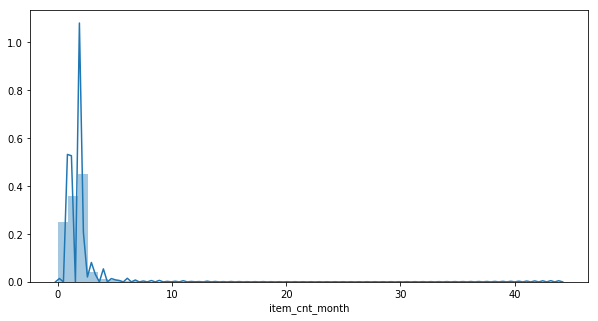

In [132]:
# density plot
plt.subplots(figsize=(10, 5))
sns.distplot(prediction_monthly['item_cnt_month'])
plt.show()


# Conclusions:

In this problem, we predict futures sales for the next month given the daily data information. We understand it is a particular problem for the time series forecasting, so the technique we analyze and implement are following machine learning framework with a time series standard. With the fact that the train and test data cannot split randomly. Time series infomration could be heavily depend on time process. As such, for each features we also consider the trend, seasonality, and idiosyncrastic data behaviors. 

With the help of the Exploratory Data Analysis (EDA), we understand the data science questions and identify the itmes sold behaviors. We removed extreme outliers for modeling purposes. This practice helps a lot for us to understand our targeting data distributions and know what we expect to model up.

To extract more features to be modelled, we have done features enginnering to obtain meaningful information. It is of much help for us to better predict the future behaviors.

Having a reserach on the problems, we have decided to chose Gradient Boosting model as our baseline to train and fit the model, with the aim of combining several weak learners to a relatively strong learner for our predicting purposes.

Throughout the whole processes, our model accuracy improves greatly (overall from ~48% to ~69% of our dev/ test data) by filtering out extreme outliers and irrelevnat features. This enhancement are also coming from the hyper parameter setting, such as we changed using tweedie distribution (poisson based) in stead of a normal distribution, as our data behaves more similar to a poisson process. In addition, from implemenitng sklearn gridsearch, we have better understand the optimal model's hyper parameters.

**(Extra Finding)** 

We also tested two alternative model: one is focus only on items sold per store level, and another one is focus on the lag 1 self-explanatory variables. Both results suggest that the model can probaly be improved in the future study by: 

(1) train model from each store levels.

(2) add autoregressive term (self-explanaotry with different lag) to our feature engineering.


# ~ The End ~
